# RNA-Seq: WT vs KO

In [102]:
suppressMessages(library(readxl))
suppressMessages(library(ggplot2))
suppressMessages(library(ggpubr))
suppressMessages(library(pheatmap))
suppressMessages(library(factoextra))
suppressMessages(library(dendextend))
suppressMessages(library(LPE))
suppressMessages(library(preprocessCore))
suppressMessages(library(ggbiplot))
suppressMessages(library(biomaRt))
suppressMessages(library(edgeR))
suppressMessages(library(DESeq2))
suppressMessages(library(DEGreport))
suppressMessages(library(RColorBrewer))
suppressMessages(library(AnnotationDbi))
suppressMessages(library(tibble))
suppressMessages(library(ggrepel))
suppressMessages(library(tidyr))
suppressMessages(library(org.Mm.eg.db))
suppressMessages(library(dplyr))
suppressMessages(library(ggpubr))
suppressMessages(library(genefilter))
suppressMessages(library(MASS))

Data loading:

In [2]:
data <- read.table("countsMatrix.tsv", sep = '\t', header=T, row.names=1)
meta <- read.table("meta_united.txt", header=T, row.names=1)

In [3]:
data = dplyr::select(data, X133, X175, X151, X134, X122, X140, X135, X124, X150, X181)

In [4]:
data <- data[rowSums(data[, ]) > 0, ]

In [5]:
head(data)

,X133,X175,X151,X134,X122,X140,X135,X124,X150,X181
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
ENSMUSG00000000001,592,565,714,446,336,531,505,456,648,609
ENSMUSG00000000028,29,56,26,33,32,28,34,54,38,31
ENSMUSG00000000031,5,4,8,6,4,3,2,5,3,1
ENSMUSG00000000037,22,23,25,12,17,22,19,14,20,35
ENSMUSG00000000049,5,8,8,10,6,8,5,7,6,6
ENSMUSG00000000056,1160,1109,1199,891,823,1135,1001,1093,1148,1256


In [6]:
meta

,sampletype,sex,genotype
,<int>,<fct>,<fct>
X133,133,female,KO
X175,175,female,WT
X151,151,female,KO
X134,134,female,KO
X122,122,male,WT
X140,140,female,WT
X135,135,female,KO
X124,124,female,WT
X150,150,female,KO


## Normalization

Normalization method: DESeq2’s median of ratios (counts divided by sample-specific size factors determined by median ratio of gene counts relative to geometric mean per gene)

Create DESeq2Dataset object:

In [7]:
dds <- DESeqDataSetFromMatrix(countData = data, colData  =  meta, design = ~ genotype)

In [8]:
dds <- estimateSizeFactors(dds)

In [9]:
dds

class: DESeqDataSet 
dim: 31277 10 
metadata(1): version
assays(1): counts
rownames(31277): ENSMUSG00000000001 ENSMUSG00000000028 ...
  ENSMUSG00000116520 ENSMUSG00000116525
rowData names(0):
colnames(10): X133 X175 ... X150 X181
colData names(4): sampletype sex genotype sizeFactor

In [10]:
normalized_counts <- counts(dds, normalized=TRUE)

## Quality Control

#### 1. Transform normalized counts using the rlog transformation:

In [11]:
rld <- rlog(dds, blind=TRUE)

####  2. Principal Component Analysis (PCA)

In [12]:
plotPCA.mystyle <- function (object, intgroup = "condition", ntop = 500, returnData = FALSE)
{
    rv <- rowVars(assay(object))
    select <- order(rv, decreasing = TRUE)[seq_len(min(ntop,
        length(rv)))]
    pca <- prcomp(t(assay(object)[select, ]))
    percentVar <- pca$sdev^2/sum(pca$sdev^2)
    if (!all(intgroup %in% names(colData(object)))) {
        stop("the argument 'intgroup' should specify columns of colData(dds)")
    }
    intgroup.df <- as.data.frame(colData(object)[, intgroup,
        drop = FALSE])
    group <- if (length(intgroup) > 1) {
        factor(apply(intgroup.df, 1, paste, collapse = " : "))
    }
    else {
        colData(object)[[intgroup]]
    }
    d1 <- data.frame(PC1 = pca$x[, 1], PC2 = pca$x[, 2], group = group,
        intgroup.df, name = colnames(object))
    d2 <- data.frame(PC1 = pca$x[, 1], PC3 = pca$x[, 3], group = group,
        intgroup.df, name = colnames(object))
    d3 <- data.frame(PC1 = pca$x[, 2], PC3 = pca$x[, 3], group = group,
        intgroup.df, name = colnames(object))
    if (returnData) {
        attr(d, "percentVar") <- percentVar[1:2]
        return(d)
    }
    p1<-ggplot(data = d1, aes_string(x = "PC1", y = "PC2", color = "group")) +
        geom_point(size = 3) + xlab(paste0("PC1: ", round(percentVar[1] *
        100), "% variance")) + ylab(paste0("PC2: ", round(percentVar[2] *
        100), "% variance")) + geom_label_repel(aes(label = colnames(data)), label.size = 0.1, box.padding = 0.2)
    p2<-ggplot(data = d2, aes_string(x = "PC1", y = "PC3", color = "group")) +
        geom_point(size = 3) + xlab(paste0("PC1: ", round(percentVar[1] *
        100), "% variance")) + ylab(paste0("PC3: ", round(percentVar[3] *
        100), "% variance")) + geom_label_repel(aes(label = colnames(data)), label.size = 0.1, box.padding = 0.2)
    
    #figure <- ggarrange(p1, p2, labels = c("A", "B"), ncol = 2, nrow = 1)
    figure <- ggarrange(p1)
    figure
    #ggsave('results/Figure_PCA.png', height = 4.5, width = 12)
    ggsave('results/Figure_PCA.png', height = 5.5, width = 7)
} 

In [13]:
plotPCA.mystyle(rld, intgroup="genotype")

#### 4. Hierarchical Clustering

In [16]:
save_pheatmap <- function(x, filename, width=1300, height=900, res = 100) {
   stopifnot(!missing(x))
   stopifnot(!missing(filename))
   png(filename, width = width, height=height, res = res)
   grid::grid.newpage()
   grid::grid.draw(x$gtable)
   dev.off()
}

Extract the rlog matrix from the object:

In [17]:
rld_mat <- assay(rld)

Compute pairwise correlation values:

In [18]:
rld_cor <- cor(rld_mat)

pdf 
  2

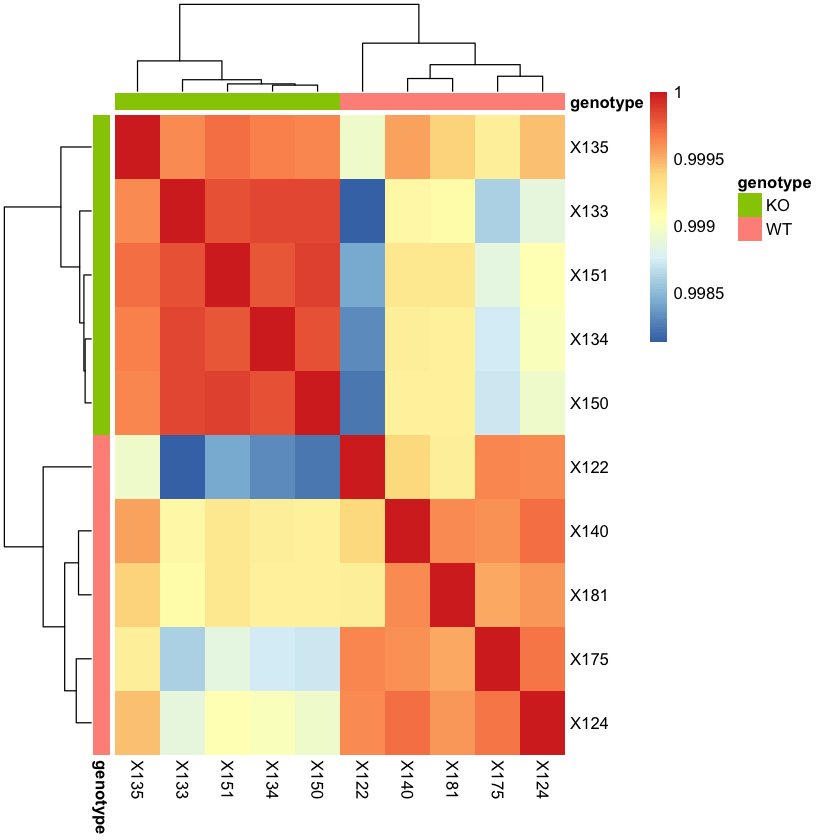

In [19]:
ph = pheatmap(rld_cor,
         annotation_row = meta[3:3],
         annotation_col = meta[3:3],
         border_color = NA, 
         fontsize = 10, 
         fontsize_row = 10, 
         height=20)

save_pheatmap(ph, filename="results/Pheatmap.png")

Select the 20 genes with the highest variance across samples:

In [22]:
topVarGenes <- head(order(-rowVars(assay(rld))), 20)

In [23]:
mat <- assay(rld)[ topVarGenes, ]
mat <- mat - rowMeans(mat)

Convertation from `ENSEMBL ID` to `gene name` for all genes:

In [24]:
ensembl <- useMart("ensembl", dataset="mmusculus_gene_ensembl")

foo <- getBM(attributes=c('ensembl_gene_id', 'external_gene_name'),
             filters = "ensembl_gene_id",
             values = rownames(mat),
             mart = ensembl)

In [25]:
rownames(mat) <- foo[['external_gene_name']]

In [26]:
my_hclust_gene <- hclust(dist(mat), method = "complete")
my_gene_col <- cutree(tree = as.dendrogram(my_hclust_gene), k = 6)
my_gene_col <- as.data.frame(my_gene_col)
colnames(my_gene_col) <- c('Cluster')

pdf 
  2

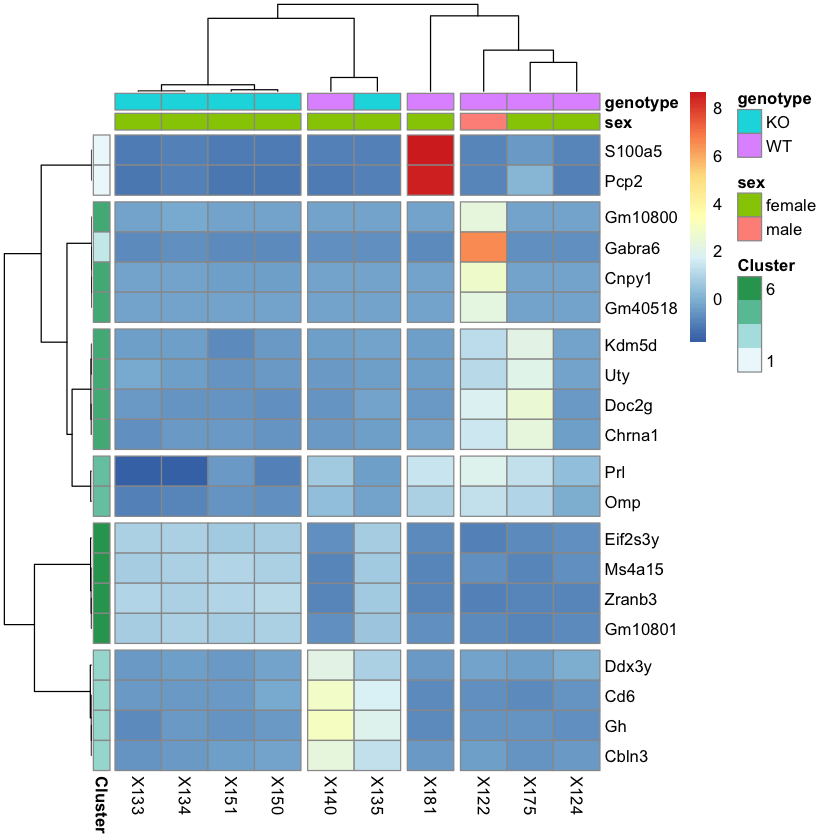

In [27]:
ph1 <- pheatmap(mat, 
         annotation_col = meta[2:3],
         annotation_row = my_gene_col,
         clustering_distance_rows = 'correlation', 
         clustering_distance_cols = 'correlation',
         cutree_rows = 6,
         cutree_col = 4)

save_pheatmap(ph1, filename="results/Pheatmap_top20genes.png")

#### 5. SIRT6 distribution

In [28]:
ensembl <- useMart("ensembl", dataset="mmusculus_gene_ensembl")
mouse_gene_ids  <- "Sirt6"

foo <- getBM(attributes=c('ensembl_gene_id',
                          'external_gene_name'),
             filters = 'mgi_symbol',
             values = mouse_gene_ids,
             mart = ensembl)

foo

ensembl_gene_id,external_gene_name
<chr>,<chr>
ENSMUSG00000034748,Sirt6


In [29]:
normalized_counts = as.data.frame(normalized_counts)

In [30]:
data_boxplot = as.data.frame(t(normalized_counts[foo[['ensembl_gene_id']], ]))
colnames(data_boxplot) <- 'SIRT6'

In [31]:
data_boxplot$genotype = meta$genotype

In [32]:
p <- ggboxplot(data_boxplot, x = "genotype",  y = "SIRT6", color = "genotype", shape = "genotype", add = "jitter")

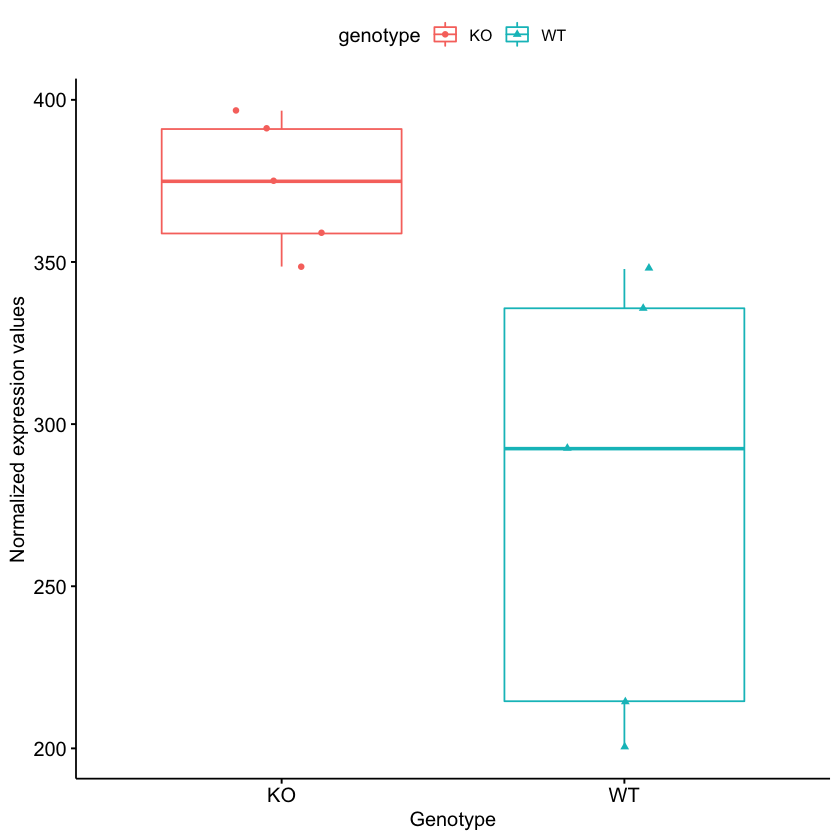

In [33]:
p+xlab("Genotype") + ylab("Normalized expression values") 

In [34]:
data_boxplot = as.data.frame(t(data[foo[['ensembl_gene_id']], ]))
colnames(data_boxplot) <- 'SIRT6'

In [35]:
data_boxplot$genotype = meta$genotype

In [36]:
p <- ggboxplot(data_boxplot, x = "genotype",  y = "SIRT6", color = "genotype", shape = "genotype", add = "jitter")

In [37]:
my_comparison <- list(c("KO", "WT"))

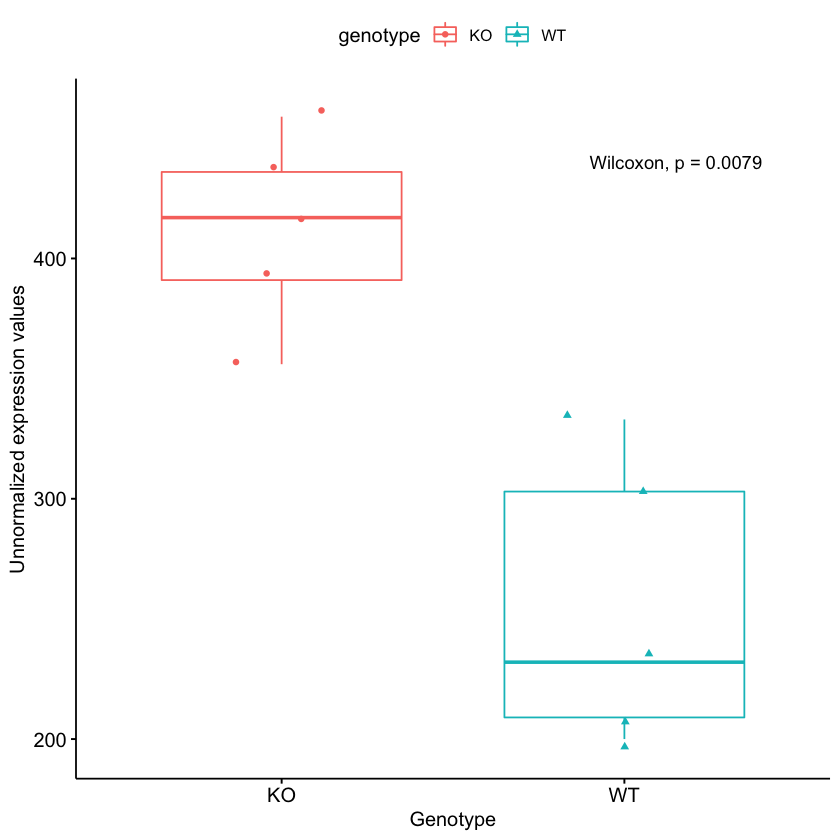

In [38]:
p+
xlab("Genotype") + ylab("Unnormalized expression values") + 
stat_compare_means(label.x = 2, label.y = 440)

In [39]:
ggsave('results/SIRT6_boxplot.png', height = 6, width = 7)

ensembl_gene_id,external_gene_name
<chr>,<chr>
ENSMUSG00000029104,Htt


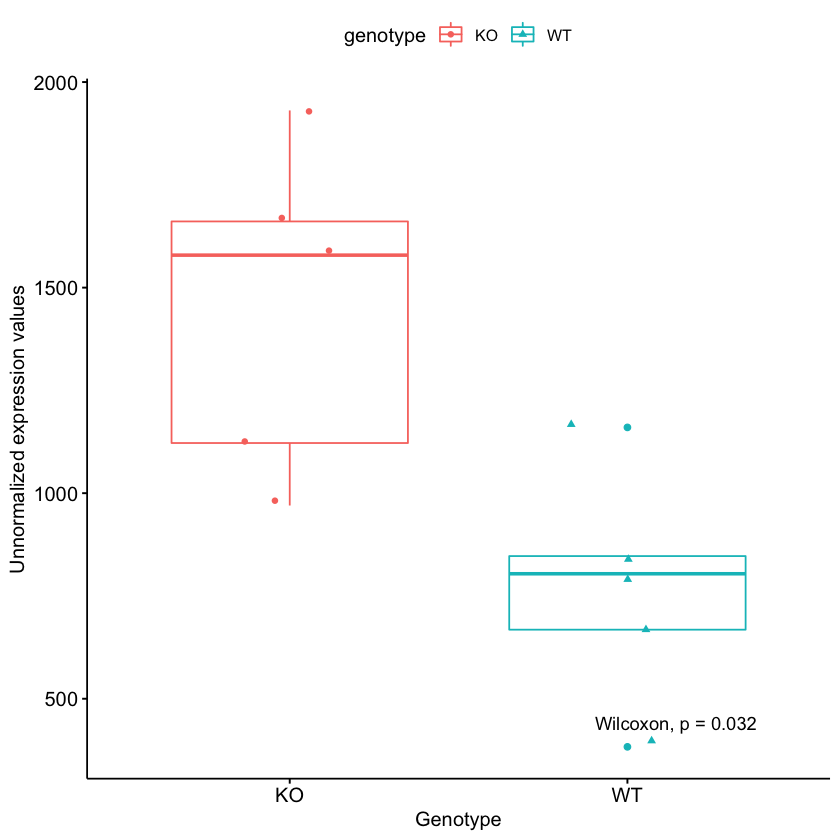

In [94]:
ensembl <- useMart("ensembl", dataset="mmusculus_gene_ensembl")
mouse_gene_ids  <- "Htt"

foo <- getBM(attributes=c('ensembl_gene_id',
                          'external_gene_name'),
             filters = 'mgi_symbol',
             values = mouse_gene_ids,
             mart = ensembl)

foo

data_boxplot = as.data.frame(t(data[foo[['ensembl_gene_id']], ]))
colnames(data_boxplot) <- 'HTT'
data_boxplot$genotype = meta$genotype

p <- ggboxplot(data_boxplot, x = "genotype",  y = "HTT", color = "genotype", shape = "genotype", add = "jitter")
my_comparison <- list(c("KO", "WT"))
p+
xlab("Genotype") + ylab("Unnormalized expression values") + 
stat_compare_means(label.x = 2, label.y = 440)

## Differential expression analysis

In [40]:
dds_factors <- DESeqDataSetFromMatrix(countData = data, colData = meta, design = ~ genotype)

In [41]:
dds_factors <- DESeq(dds_factors)

estimating size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing


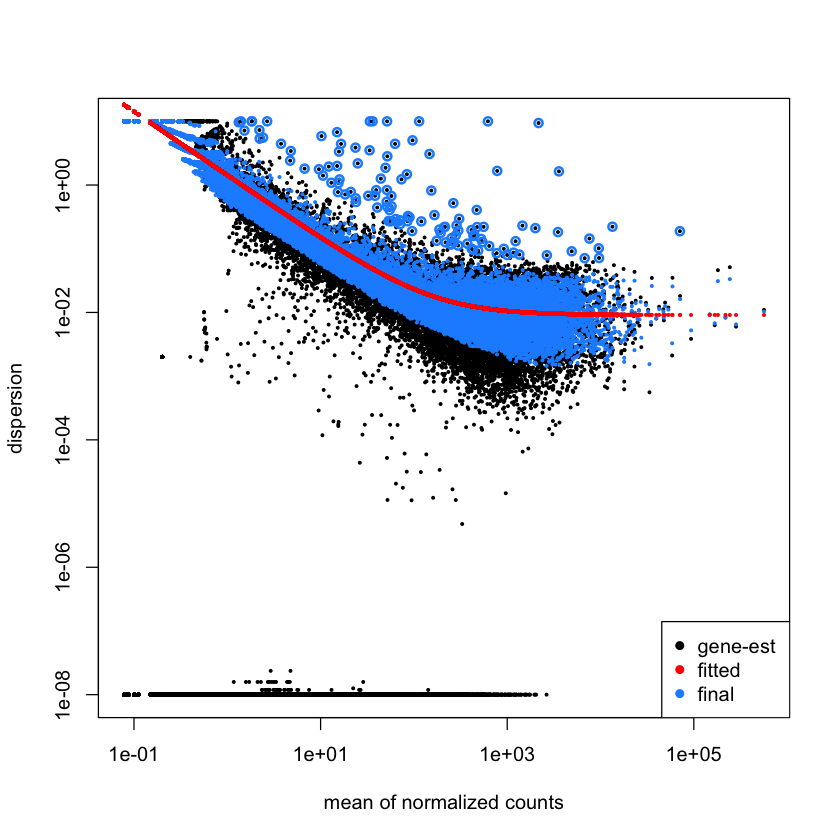

In [42]:
plotDispEsts(dds_factors)

Contrasts:

In [43]:
contrast_genotype <- c("genotype", "KO", "WT")

In [44]:
res_unshrunken <- results(dds_factors, contrast=contrast_genotype, alpha = 0.05)

In [45]:
res <- lfcShrink(dds_factors, contrast=contrast_genotype, res=res_unshrunken)

using 'normal' for LFC shrinkage, the Normal prior from Love et al (2014).

Note that type='apeglm' and type='ashr' have shown to have less bias than type='normal'.
See ?lfcShrink for more details on shrinkage type, and the DESeq2 vignette.
Reference: https://doi.org/10.1093/bioinformatics/bty895


In [46]:
tibble_meta <- meta %>% 
  rownames_to_column(var = "samplename") %>% 
  as_tibble()

normalized_counts <- normalized_counts %>% 
  data.frame() %>%
  rownames_to_column(var = "gene") %>% 
  as_tibble()

Set thresholds:

In [47]:
padj.cutoff <- 0.05
lfc.cutoff <- 0.58

In [48]:
res_tb <- res %>%
  data.frame() %>%
  rownames_to_column(var="gene") %>% 
  as_tibble()

In [49]:
sig <- res_tb %>%
        filter(padj < padj.cutoff & abs(log2FoldChange) > lfc.cutoff)

In [50]:
sig <- as.data.frame(sig)

In [51]:
length(sig$gene)

[1] 3590

In [52]:
write.table(sig, file = "results/csv/all_signif_genes.csv", sep="\t", quote=F, col.names=NA)

In [53]:
top20_sig_genes <- res_tb %>% 
        arrange(padj) %>% 
        pull(gene) %>% 
        head(n=20)

In [54]:
top20_sig_norm <- sig %>%
        filter(gene %in% top20_sig_genes)

In [55]:
ensembl <- useMart("ensembl", dataset="mmusculus_gene_ensembl")

foo <- getBM(attributes=c('ensembl_gene_id', 'external_gene_name'),
             filters = "ensembl_gene_id",
             values = top20_sig_norm$gene,
             mart = ensembl)

In [56]:
top20_sig_norm$gene <- foo$external_gene_name

In [57]:
write.table(top20_sig_norm, file = "results/csv/top20_signif_genes.csv", sep="\t", quote=F, col.names=NA)

Joining, by = "samplename"


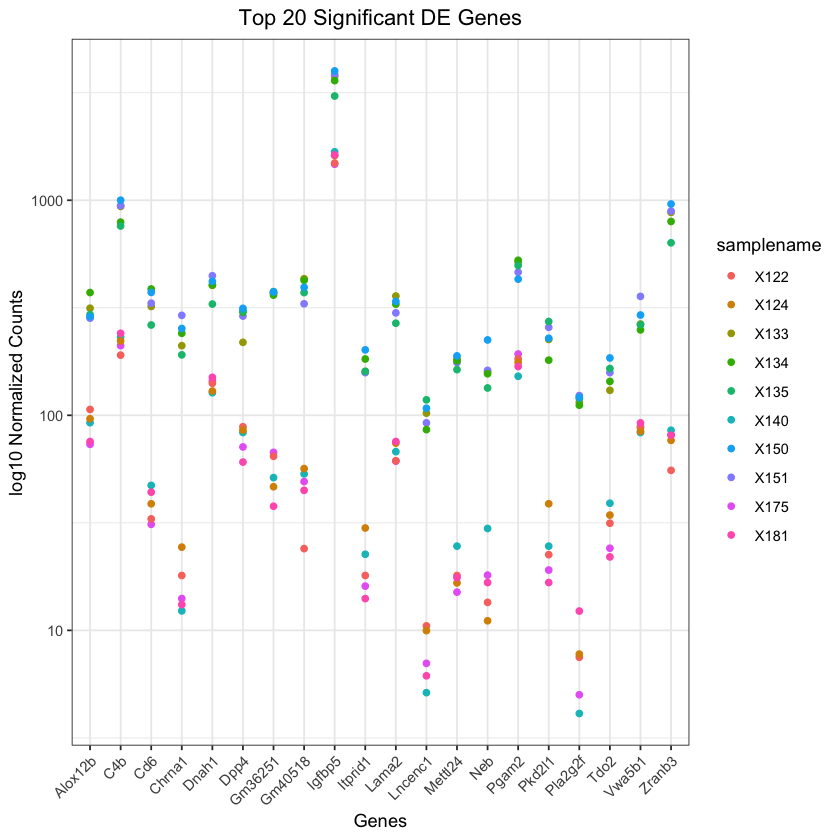

In [58]:
top20 <- normalized_counts %>%
        filter(gene %in% top20_sig_genes)

top20$gene <- foo$external_gene_name

gathered_top20 <- top20 %>%
  gather(colnames(top20)[2:11], key = "samplename", value = "normalized_counts")

gathered_top20 <- inner_join(tibble_meta, gathered_top20)

ggplot(gathered_top20) +
        geom_point(aes(x = gene, y = normalized_counts, color = samplename)) +
        scale_y_log10() +
        xlab("Genes") +
        ylab("log10 Normalized Counts") +
        ggtitle("Top 20 Significant DE Genes") +
        theme_bw() +
    theme(axis.text.x = element_text(angle = 45, hjust = 1)) +
    theme(plot.title = element_text(hjust = 0.5))

ggsave('results/Top20tDEGenes.png', height = 6, width = 7)

## Functional Analysis

In [105]:
suppressMessages(library(DOSE))
suppressMessages(library(pathview))
suppressMessages(library(clusterProfiler))
suppressMessages(library(EnsDb.Mmusculus.v79))
suppressMessages(library(enrichplot))
suppressMessages(library(pathview))
suppressMessages(library(SPIA))

In [61]:
annotations_edb <- AnnotationDbi::select(EnsDb.Mmusculus.v79,
                                           keys = sig$gene,
                                           columns = c("SYMBOL", "ENTREZID","GENEBIOTYPE"),
                                           keytype = "GENEID")

In [62]:
non_duplicates_idx <- which(duplicated(annotations_edb$SYMBOL) == FALSE)
annotations_edb <- annotations_edb[non_duplicates_idx, ]

In [63]:
res_ids <- inner_join(sig, annotations_edb, by=c("gene"="GENEID")) 

In [64]:
all_genes <- as.character(rownames(data))

In [65]:
sig_filtered <- dplyr::filter(res_ids, padj < 0.05)
sig_genes <- as.character(sig_filtered$gene)

In [66]:
## Run GO enrichment analysis 
ego <- enrichGO(gene = sig_genes, 
                universe = all_genes,
                keyType = "ENSEMBL",
                OrgDb = org.Mm.eg.db, 
                ont = "BP", 
                pAdjustMethod = "BH", 
                pvalueCutoff = 0.05, 
                readable = TRUE)
                
## Output results from GO analysis to a table
cluster_summary <- data.frame(ego)

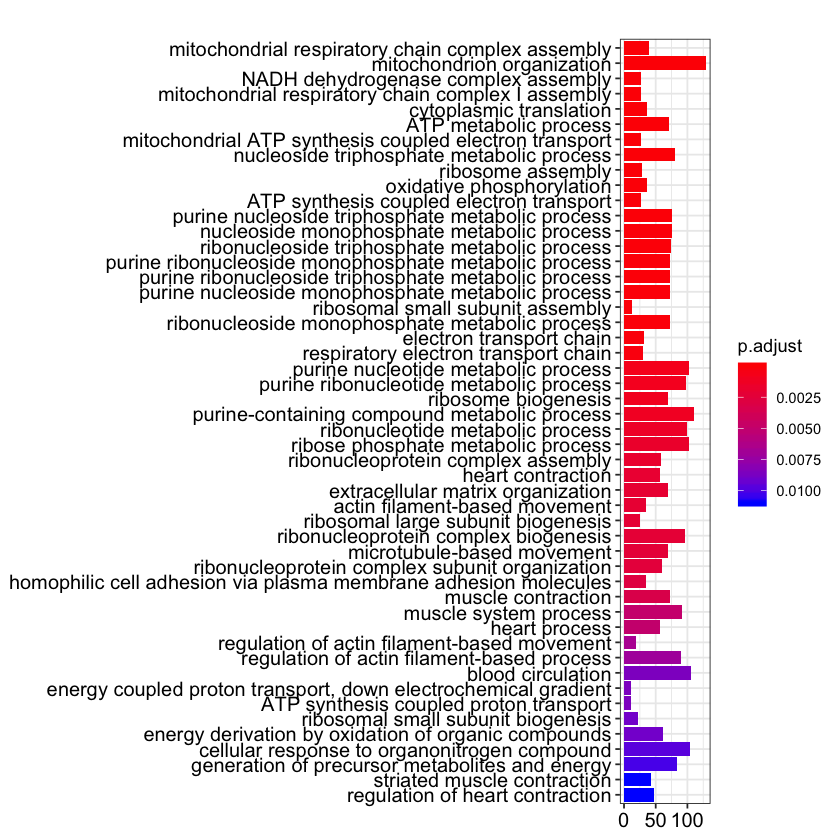

In [68]:
barplot(ego, showCategory=50)
ggsave('results/enrichGO/barplot.png', height = 11, width = 17.5)

In [69]:
write.csv(cluster_summary, "results/csv/cluster_summary_enrichGO_BP.csv")

wrong orderBy parameter; set to default `orderBy = "x"`


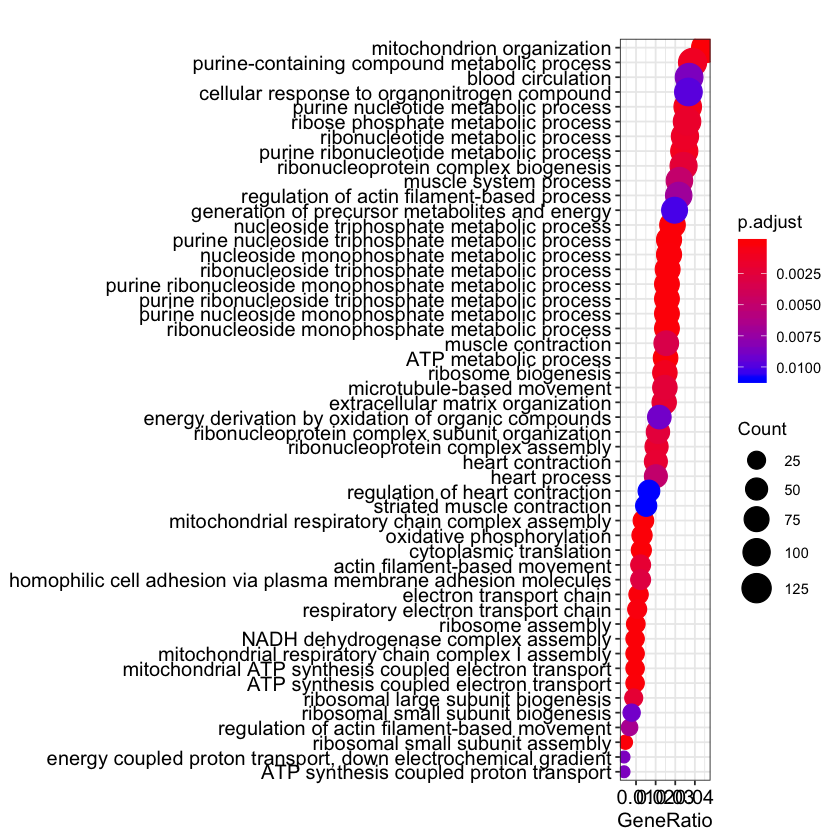

In [70]:
dotplot(ego, showCategory=50)
ggsave('results/enrichGO/enrichGO_BP.png', height = 11, width = 13.5)

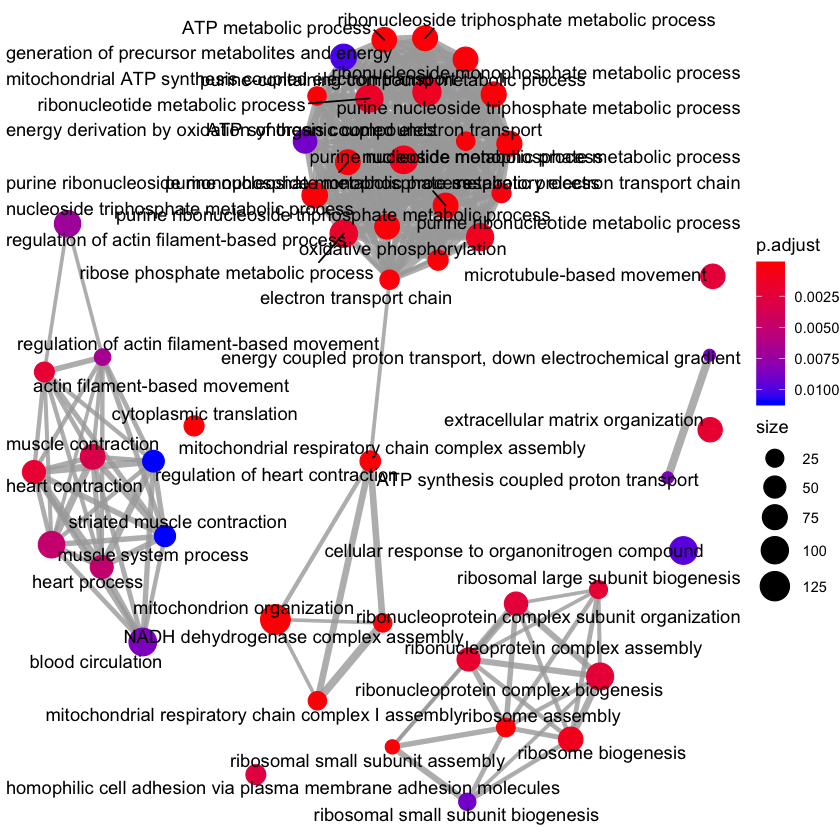

In [71]:
emapplot(ego, showCategory = 50)
ggsave('results/enrichGO/enrichGO_BP_graph.png', height = 9, width = 13)

In [74]:
de_foldchanges <- sig_filtered$log2FoldChange

In [75]:
names(de_foldchanges) <- sig_filtered$gene

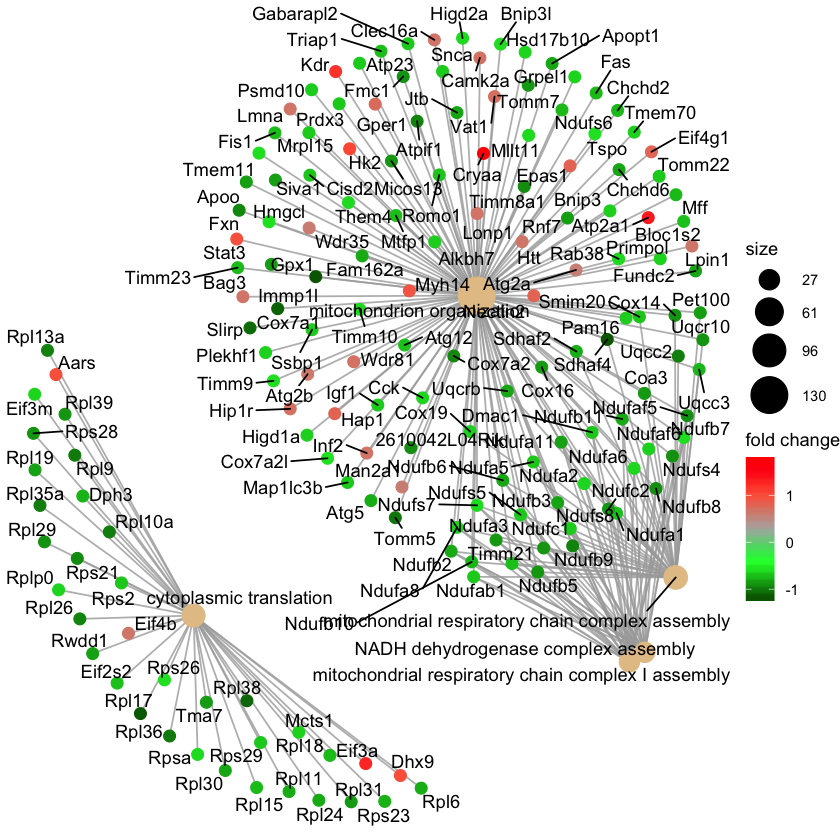

In [76]:
#de_foldchanges <- ifelse(de_foldchanges > 2, 2, de_foldchanges)
#de_foldchanges <- ifelse(de_foldchanges < -2, -2, de_foldchanges)

cnetplot(ego, 
         categorySize="pvalue", 
         showCategory = 5, 
         foldChange=de_foldchanges, 
         vertex.label.font=6)

ggsave('results/category_netplot_top5.png', height = 9, width = 13)

### Gene set enrichment analysis

Remove any NA values

In [78]:
res_entrez <- dplyr::filter(res_ids, ENTREZID != "NA")

Remove any Entrez duplicates

In [79]:
res_entrez <- res_entrez[which(duplicated(res_entrez$ENTREZID) == F), ]

In [80]:
foldchanges <- res_entrez$log2FoldChange

In [81]:
names(foldchanges) <- res_entrez$ENTREZID

In [ ]:
length(res_ids$gene)

In [83]:
length(foldchanges)

[1] 2634

In [84]:
foldchanges <- sort(foldchanges, decreasing = TRUE)

In [85]:
## GSEA using gene sets from KEGG pathways
gseaKEGG <- gseKEGG(geneList = foldchanges, # ordered named vector of fold changes (Entrez IDs are the associated names)
              organism = "mmu", # supported organisms listed below
              nPerm = 1000, # default number permutations
              minGSSize = 20, # minimum gene set size (# genes in set) - change to test more sets or recover sets with fewer # genes
              pvalueCutoff = 0.05, # padj cutoff value
              verbose = FALSE)

## Extract the GSEA results
gseaKEGG_results <- gseaKEGG@result

In [86]:
gseaKEGG_results

,ID,Description,setSize,enrichmentScore,NES,pvalue,p.adjust,qvalues,rank,leading_edge,core_enrichment
,<chr>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
mmu04510,mmu04510,Focal adhesion,53,0.4079450,2.410800,0.001336898,0.02253086,0.01429500,677,"tags=55%, list=26%, signal=41%",16773/665033/245026/21923/192897/17295/14257/16542/12843/12835/21960/213435/14254/12828/107589/16779/170736/21827/68794/16776/238564/14268/16001/21826/14205/12827/22371/330662/13649
mmu04020,mmu04020,Calcium signaling pathway,45,0.4219335,2.345574,0.001386963,0.02253086,0.01429500,1447,"tags=96%, list=55%, signal=44%",12373/11937/213435/15464/16867/110891/21924/107589/18125/18216/12291/320707/18436/238564/12292/70405/16438/12287/74055/21390/13649/104111/12286/239556/13867/18596/18803/12322/14814/12290/18750/11938/20866/16439/12288/67972/14810/20191/20541/13866/13492/18797/11515
mmu04512,mmu04512,ECM-receptor interaction,28,0.5115497,2.398350,0.001506024,0.02253086,0.01429500,1044,"tags=89%, list=40%, signal=54%",16773/665033/245026/21923/192897/12843/12835/21960/12828/16779/21827/16776/14268/21826/12827/22371/242022/75209/12842/16777/64051/68553/109700/16775/12505
mmu04974,mmu04974,Protein digestion and absorption,26,0.5005705,2.274126,0.003030303,0.02253086,0.01429500,932,"tags=77%, list=35%, signal=50%",69700/665033/27222/245026/13482/213945/12843/12835/110891/12828/12815/11928/12831/98660/12827/12842/16529/50934/12817/68553
mmu05410,mmu05410,Hypertrophic cardiomyopathy (HCM),24,0.5419677,2.384449,0.003030303,0.02253086,0.01429500,266,"tags=46%, list=10%, signal=42%",22138/16773/20391/17868/11937/192897/11421/110891/21924/56808/13346
mmu05414,mmu05414,Dilated cardiomyopathy (DCM),26,0.4736022,2.151607,0.003030303,0.02253086,0.01429500,266,"tags=38%, list=10%, signal=35%",22138/16773/20391/17868/11937/192897/110891/21924/56808/13346
mmu05012,mmu05012,Parkinson disease,53,-0.5652838,-4.215134,0.003937008,0.02253086,0.01429500,1024,"tags=92%, list=39%, signal=58%",78330/17991/68375/67680/67942/225887/595136/68202/66925/54405/11950/12861/66594/11949/407785/68342/12869/22272/13063/104130/230075/67530/72900/66495/66414/12864/28080/69875/66091/66046/66377/68197/66152/17993/110323/12859/67264/12866/66218/12857/12867/66576/67126/66416/68194/12865/17992/66142
mmu04932,mmu04932,Non-alcoholic fatty liver disease (NAFLD),55,-0.4842679,-3.648268,0.003968254,0.02253086,0.01429500,1024,"tags=85%, list=39%, signal=53%",78330/13665/17991/68375/67680/225887/595136/68202/66925/54405/12861/66594/14102/407785/68342/12869/21428/22272/13063/104130/230075/67530/72900/66495/66414/12864/69875/66091/66046/66377/68197/66152/17993/110323/12859/67264/12866/66218/12857/12867/66576/66416/68194/12865/17992/66142
mmu00190,mmu00190,Oxidative phosphorylation,60,-0.5307688,-4.094820,0.004065041,0.02253086,0.01429500,1161,"tags=95%, list=44%, signal=54%",20463/66916/11974/75406/66144/67130/78330/17991/114143/68375/67680/67942/225887/595136/68202/66925/54405/11950/12861/66594/11949/407785/68342/12869/22272/104130/230075/67530/72900/66495/66414/12864/28080/69875/57423/66091/66046/66377/68197/66152/17993/110323/12859/11958/67264/12866/66218/12857/12867/66576/67126/66416/68194/12865/17992/66142


In [87]:
write.csv(gseaKEGG_results, "results/csv/KEGG_results.csv", quote=F)

In [90]:
browseKEGG(ego, 'mmu05012')

First unload dplyr to avoid conflicts:

In [101]:
detach("package:dplyr", unload=TRUE) 

Warning message:
"'dplyr' namespace cannot be unloaded:
  namespace 'dplyr' is imported by 'DEGreport', 'tidyr', 'ggpubr', 'europepmc', 'broom', 'tidygraph', 'ggraph' so cannot be unloaded"

In [99]:
get_kegg_plots <- function(x) {
   pathview(gene.data = foldchanges, pathway.id = gseaKEGG_results$ID[x], species = "mmu", 
            limit = list(gene = 2, cpd = 1))
}

purrr::map(1:length(gseaKEGG_results$ID), get_kegg_plots)

'select()' returned 1:1 mapping between keys and columns
Info: Working in directory /Users/dmitriismirnov/SIRT6/WT_vs_KO
Info: Writing image file mmu04510.pathview.png
'select()' returned 1:1 mapping between keys and columns
Info: Working in directory /Users/dmitriismirnov/SIRT6/WT_vs_KO
Info: Writing image file mmu04020.pathview.png
'select()' returned 1:1 mapping between keys and columns
Info: Working in directory /Users/dmitriismirnov/SIRT6/WT_vs_KO
Info: Writing image file mmu04512.pathview.png
'select()' returned 1:1 mapping between keys and columns
Info: Working in directory /Users/dmitriismirnov/SIRT6/WT_vs_KO
Info: Writing image file mmu04974.pathview.png
Info: some node width is different from others, and hence adjusted!
'select()' returned 1:1 mapping between keys and columns
Info: Working in directory /Users/dmitriismirnov/SIRT6/WT_vs_KO
Info: Writing image file mmu05410.pathview.png
'select()' returned 1:1 mapping between keys and columns
Info: Working in directory /Users/d

  Consider 'structure(list(), *)' instead."Warning message in structure(x$children, class = "XMLNodeList"):
"Calling 'structure(NULL, *)' is deprecated, as NULL cannot have attributes.
  Consider 'structure(list(), *)' instead."Warning message in structure(x$children, class = "XMLNodeList"):
"Calling 'structure(NULL, *)' is deprecated, as NULL cannot have attributes.
  Consider 'structure(list(), *)' instead."Warning message in structure(x$children, class = "XMLNodeList"):
"Calling 'structure(NULL, *)' is deprecated, as NULL cannot have attributes.
  Consider 'structure(list(), *)' instead."Warning message in structure(x$children, class = "XMLNodeList"):
"Calling 'structure(NULL, *)' is deprecated, as NULL cannot have attributes.
  Consider 'structure(list(), *)' instead."Warning message in structure(x$children, class = "XMLNodeList"):
"Calling 'structure(NULL, *)' is deprecated, as NULL cannot have attributes.
  Consider 'structure(list(), *)' instead."Warning message in structure(x$c

  Consider 'structure(list(), *)' instead."Warning message in structure(x$children, class = "XMLNodeList"):
"Calling 'structure(NULL, *)' is deprecated, as NULL cannot have attributes.
  Consider 'structure(list(), *)' instead."Warning message in structure(x$children, class = "XMLNodeList"):
"Calling 'structure(NULL, *)' is deprecated, as NULL cannot have attributes.
  Consider 'structure(list(), *)' instead."Warning message in structure(x$children, class = "XMLNodeList"):
"Calling 'structure(NULL, *)' is deprecated, as NULL cannot have attributes.
  Consider 'structure(list(), *)' instead."Warning message in structure(x$children, class = "XMLNodeList"):
"Calling 'structure(NULL, *)' is deprecated, as NULL cannot have attributes.
  Consider 'structure(list(), *)' instead."Warning message in structure(x$children, class = "XMLNodeList"):
"Calling 'structure(NULL, *)' is deprecated, as NULL cannot have attributes.
  Consider 'structure(list(), *)' instead."Warning message in structure(x$c

  Consider 'structure(list(), *)' instead."Warning message in structure(x$children, class = "XMLNodeList"):
"Calling 'structure(NULL, *)' is deprecated, as NULL cannot have attributes.
  Consider 'structure(list(), *)' instead."Warning message in structure(x$children, class = "XMLNodeList"):
"Calling 'structure(NULL, *)' is deprecated, as NULL cannot have attributes.
  Consider 'structure(list(), *)' instead."Warning message in structure(x$children, class = "XMLNodeList"):
"Calling 'structure(NULL, *)' is deprecated, as NULL cannot have attributes.
  Consider 'structure(list(), *)' instead."Warning message in structure(x$children, class = "XMLNodeList"):
"Calling 'structure(NULL, *)' is deprecated, as NULL cannot have attributes.
  Consider 'structure(list(), *)' instead."Warning message in structure(x$children, class = "XMLNodeList"):
"Calling 'structure(NULL, *)' is deprecated, as NULL cannot have attributes.
  Consider 'structure(list(), *)' instead."Warning message in structure(x$c

  Consider 'structure(list(), *)' instead."Warning message in structure(x$children, class = "XMLNodeList"):
"Calling 'structure(NULL, *)' is deprecated, as NULL cannot have attributes.
  Consider 'structure(list(), *)' instead."Warning message in structure(x$children, class = "XMLNodeList"):
"Calling 'structure(NULL, *)' is deprecated, as NULL cannot have attributes.
  Consider 'structure(list(), *)' instead."Warning message in structure(x$children, class = "XMLNodeList"):
"Calling 'structure(NULL, *)' is deprecated, as NULL cannot have attributes.
  Consider 'structure(list(), *)' instead."Warning message in structure(x$children, class = "XMLNodeList"):
"Calling 'structure(NULL, *)' is deprecated, as NULL cannot have attributes.
  Consider 'structure(list(), *)' instead."Warning message in structure(x$children, class = "XMLNodeList"):
"Calling 'structure(NULL, *)' is deprecated, as NULL cannot have attributes.
  Consider 'structure(list(), *)' instead."Warning message in structure(x$c

  Consider 'structure(list(), *)' instead."Warning message in structure(x$children, class = "XMLNodeList"):
"Calling 'structure(NULL, *)' is deprecated, as NULL cannot have attributes.
  Consider 'structure(list(), *)' instead."Warning message in structure(x$children, class = "XMLNodeList"):
"Calling 'structure(NULL, *)' is deprecated, as NULL cannot have attributes.
  Consider 'structure(list(), *)' instead."Warning message in structure(x$children, class = "XMLNodeList"):
"Calling 'structure(NULL, *)' is deprecated, as NULL cannot have attributes.
  Consider 'structure(list(), *)' instead."Warning message in structure(x$children, class = "XMLNodeList"):
"Calling 'structure(NULL, *)' is deprecated, as NULL cannot have attributes.
  Consider 'structure(list(), *)' instead."Warning message in structure(x$children, class = "XMLNodeList"):
"Calling 'structure(NULL, *)' is deprecated, as NULL cannot have attributes.
  Consider 'structure(list(), *)' instead."Warning message in structure(x$c

  Consider 'structure(list(), *)' instead."Warning message in structure(x$children, class = "XMLNodeList"):
"Calling 'structure(NULL, *)' is deprecated, as NULL cannot have attributes.
  Consider 'structure(list(), *)' instead."Warning message in structure(x$children, class = "XMLNodeList"):
"Calling 'structure(NULL, *)' is deprecated, as NULL cannot have attributes.
  Consider 'structure(list(), *)' instead."Warning message in structure(x$children, class = "XMLNodeList"):
"Calling 'structure(NULL, *)' is deprecated, as NULL cannot have attributes.
  Consider 'structure(list(), *)' instead."Warning message in structure(x$children, class = "XMLNodeList"):
"Calling 'structure(NULL, *)' is deprecated, as NULL cannot have attributes.
  Consider 'structure(list(), *)' instead."Warning message in structure(x$children, class = "XMLNodeList"):
"Calling 'structure(NULL, *)' is deprecated, as NULL cannot have attributes.
  Consider 'structure(list(), *)' instead."Warning message in structure(x$c

  Consider 'structure(list(), *)' instead."Warning message in structure(x$children, class = "XMLNodeList"):
"Calling 'structure(NULL, *)' is deprecated, as NULL cannot have attributes.
  Consider 'structure(list(), *)' instead."Warning message in structure(x$children, class = "XMLNodeList"):
"Calling 'structure(NULL, *)' is deprecated, as NULL cannot have attributes.
  Consider 'structure(list(), *)' instead."Warning message in structure(x$children, class = "XMLNodeList"):
"Calling 'structure(NULL, *)' is deprecated, as NULL cannot have attributes.
  Consider 'structure(list(), *)' instead."Warning message in structure(x$children, class = "XMLNodeList"):
"Calling 'structure(NULL, *)' is deprecated, as NULL cannot have attributes.
  Consider 'structure(list(), *)' instead."Warning message in structure(x$children, class = "XMLNodeList"):
"Calling 'structure(NULL, *)' is deprecated, as NULL cannot have attributes.
  Consider 'structure(list(), *)' instead."Warning message in structure(x$c

  Consider 'structure(list(), *)' instead."Warning message in structure(x$children, class = "XMLNodeList"):
"Calling 'structure(NULL, *)' is deprecated, as NULL cannot have attributes.
  Consider 'structure(list(), *)' instead."Warning message in structure(x$children, class = "XMLNodeList"):
"Calling 'structure(NULL, *)' is deprecated, as NULL cannot have attributes.
  Consider 'structure(list(), *)' instead."Warning message in structure(x$children, class = "XMLNodeList"):
"Calling 'structure(NULL, *)' is deprecated, as NULL cannot have attributes.
  Consider 'structure(list(), *)' instead."Warning message in structure(x$children, class = "XMLNodeList"):
"Calling 'structure(NULL, *)' is deprecated, as NULL cannot have attributes.
  Consider 'structure(list(), *)' instead."Warning message in structure(x$children, class = "XMLNodeList"):
"Calling 'structure(NULL, *)' is deprecated, as NULL cannot have attributes.
  Consider 'structure(list(), *)' instead."Warning message in structure(x$c

  Consider 'structure(list(), *)' instead."Warning message in structure(x$children, class = "XMLNodeList"):
"Calling 'structure(NULL, *)' is deprecated, as NULL cannot have attributes.
  Consider 'structure(list(), *)' instead."Warning message in structure(x$children, class = "XMLNodeList"):
"Calling 'structure(NULL, *)' is deprecated, as NULL cannot have attributes.
  Consider 'structure(list(), *)' instead."Warning message in structure(x$children, class = "XMLNodeList"):
"Calling 'structure(NULL, *)' is deprecated, as NULL cannot have attributes.
  Consider 'structure(list(), *)' instead."Warning message in structure(x$children, class = "XMLNodeList"):
"Calling 'structure(NULL, *)' is deprecated, as NULL cannot have attributes.
  Consider 'structure(list(), *)' instead."Warning message in structure(x$children, class = "XMLNodeList"):
"Calling 'structure(NULL, *)' is deprecated, as NULL cannot have attributes.
  Consider 'structure(list(), *)' instead."Warning message in structure(x$c

  Consider 'structure(list(), *)' instead."Warning message in structure(x$children, class = "XMLNodeList"):
"Calling 'structure(NULL, *)' is deprecated, as NULL cannot have attributes.
  Consider 'structure(list(), *)' instead."Warning message in structure(x$children, class = "XMLNodeList"):
"Calling 'structure(NULL, *)' is deprecated, as NULL cannot have attributes.
  Consider 'structure(list(), *)' instead."Warning message in structure(x$children, class = "XMLNodeList"):
"Calling 'structure(NULL, *)' is deprecated, as NULL cannot have attributes.
  Consider 'structure(list(), *)' instead."Warning message in structure(x$children, class = "XMLNodeList"):
"Calling 'structure(NULL, *)' is deprecated, as NULL cannot have attributes.
  Consider 'structure(list(), *)' instead."Warning message in structure(x$children, class = "XMLNodeList"):
"Calling 'structure(NULL, *)' is deprecated, as NULL cannot have attributes.
  Consider 'structure(list(), *)' instead."Warning message in structure(x$c

  Consider 'structure(list(), *)' instead."Warning message in structure(x$children, class = "XMLNodeList"):
"Calling 'structure(NULL, *)' is deprecated, as NULL cannot have attributes.
  Consider 'structure(list(), *)' instead."Warning message in structure(x$children, class = "XMLNodeList"):
"Calling 'structure(NULL, *)' is deprecated, as NULL cannot have attributes.
  Consider 'structure(list(), *)' instead."Warning message in structure(x$children, class = "XMLNodeList"):
"Calling 'structure(NULL, *)' is deprecated, as NULL cannot have attributes.
  Consider 'structure(list(), *)' instead."Warning message in structure(x$children, class = "XMLNodeList"):
"Calling 'structure(NULL, *)' is deprecated, as NULL cannot have attributes.
  Consider 'structure(list(), *)' instead."Warning message in structure(x$children, class = "XMLNodeList"):
"Calling 'structure(NULL, *)' is deprecated, as NULL cannot have attributes.
  Consider 'structure(list(), *)' instead."Warning message in structure(x$c

  Consider 'structure(list(), *)' instead."Warning message in structure(x$children, class = "XMLNodeList"):
"Calling 'structure(NULL, *)' is deprecated, as NULL cannot have attributes.
  Consider 'structure(list(), *)' instead."Warning message in structure(x$children, class = "XMLNodeList"):
"Calling 'structure(NULL, *)' is deprecated, as NULL cannot have attributes.
  Consider 'structure(list(), *)' instead."Warning message in structure(x$children, class = "XMLNodeList"):
"Calling 'structure(NULL, *)' is deprecated, as NULL cannot have attributes.
  Consider 'structure(list(), *)' instead."Warning message in structure(x$children, class = "XMLNodeList"):
"Calling 'structure(NULL, *)' is deprecated, as NULL cannot have attributes.
  Consider 'structure(list(), *)' instead."Warning message in structure(x$children, class = "XMLNodeList"):
"Calling 'structure(NULL, *)' is deprecated, as NULL cannot have attributes.
  Consider 'structure(list(), *)' instead."Warning message in structure(x$c

  Consider 'structure(list(), *)' instead."Warning message in structure(x$children, class = "XMLNodeList"):
"Calling 'structure(NULL, *)' is deprecated, as NULL cannot have attributes.
  Consider 'structure(list(), *)' instead."Warning message in structure(x$children, class = "XMLNodeList"):
"Calling 'structure(NULL, *)' is deprecated, as NULL cannot have attributes.
  Consider 'structure(list(), *)' instead."Warning message in structure(x$children, class = "XMLNodeList"):
"Calling 'structure(NULL, *)' is deprecated, as NULL cannot have attributes.
  Consider 'structure(list(), *)' instead."Warning message in structure(x$children, class = "XMLNodeList"):
"Calling 'structure(NULL, *)' is deprecated, as NULL cannot have attributes.
  Consider 'structure(list(), *)' instead."Warning message in structure(x$children, class = "XMLNodeList"):
"Calling 'structure(NULL, *)' is deprecated, as NULL cannot have attributes.
  Consider 'structure(list(), *)' instead."Warning message in structure(x$c

  Consider 'structure(list(), *)' instead."Warning message in structure(x$children, class = "XMLNodeList"):
"Calling 'structure(NULL, *)' is deprecated, as NULL cannot have attributes.
  Consider 'structure(list(), *)' instead."Warning message in structure(x$children, class = "XMLNodeList"):
"Calling 'structure(NULL, *)' is deprecated, as NULL cannot have attributes.
  Consider 'structure(list(), *)' instead."Warning message in structure(x$children, class = "XMLNodeList"):
"Calling 'structure(NULL, *)' is deprecated, as NULL cannot have attributes.
  Consider 'structure(list(), *)' instead."Warning message in structure(x$children, class = "XMLNodeList"):
"Calling 'structure(NULL, *)' is deprecated, as NULL cannot have attributes.
  Consider 'structure(list(), *)' instead."Warning message in structure(x$children, class = "XMLNodeList"):
"Calling 'structure(NULL, *)' is deprecated, as NULL cannot have attributes.
  Consider 'structure(list(), *)' instead."Warning message in structure(x$c

  Consider 'structure(list(), *)' instead."Warning message in structure(x$children, class = "XMLNodeList"):
"Calling 'structure(NULL, *)' is deprecated, as NULL cannot have attributes.
  Consider 'structure(list(), *)' instead."Warning message in structure(x$children, class = "XMLNodeList"):
"Calling 'structure(NULL, *)' is deprecated, as NULL cannot have attributes.
  Consider 'structure(list(), *)' instead."Warning message in structure(x$children, class = "XMLNodeList"):
"Calling 'structure(NULL, *)' is deprecated, as NULL cannot have attributes.
  Consider 'structure(list(), *)' instead."Warning message in structure(x$children, class = "XMLNodeList"):
"Calling 'structure(NULL, *)' is deprecated, as NULL cannot have attributes.
  Consider 'structure(list(), *)' instead."Warning message in structure(x$children, class = "XMLNodeList"):
"Calling 'structure(NULL, *)' is deprecated, as NULL cannot have attributes.
  Consider 'structure(list(), *)' instead."Warning message in structure(x$c

  Consider 'structure(list(), *)' instead."Warning message in structure(x$children, class = "XMLNodeList"):
"Calling 'structure(NULL, *)' is deprecated, as NULL cannot have attributes.
  Consider 'structure(list(), *)' instead."Warning message in structure(x$children, class = "XMLNodeList"):
"Calling 'structure(NULL, *)' is deprecated, as NULL cannot have attributes.
  Consider 'structure(list(), *)' instead."Warning message in structure(x$children, class = "XMLNodeList"):
"Calling 'structure(NULL, *)' is deprecated, as NULL cannot have attributes.
  Consider 'structure(list(), *)' instead."Warning message in structure(x$children, class = "XMLNodeList"):
"Calling 'structure(NULL, *)' is deprecated, as NULL cannot have attributes.
  Consider 'structure(list(), *)' instead."Warning message in structure(x$children, class = "XMLNodeList"):
"Calling 'structure(NULL, *)' is deprecated, as NULL cannot have attributes.
  Consider 'structure(list(), *)' instead."Warning message in structure(x$c

  Consider 'structure(list(), *)' instead."Warning message in structure(x$children, class = "XMLNodeList"):
"Calling 'structure(NULL, *)' is deprecated, as NULL cannot have attributes.
  Consider 'structure(list(), *)' instead."Warning message in structure(x$children, class = "XMLNodeList"):
"Calling 'structure(NULL, *)' is deprecated, as NULL cannot have attributes.
  Consider 'structure(list(), *)' instead."Warning message in structure(x$children, class = "XMLNodeList"):
"Calling 'structure(NULL, *)' is deprecated, as NULL cannot have attributes.
  Consider 'structure(list(), *)' instead."Warning message in structure(x$children, class = "XMLNodeList"):
"Calling 'structure(NULL, *)' is deprecated, as NULL cannot have attributes.
  Consider 'structure(list(), *)' instead."Warning message in structure(x$children, class = "XMLNodeList"):
"Calling 'structure(NULL, *)' is deprecated, as NULL cannot have attributes.
  Consider 'structure(list(), *)' instead."Warning message in structure(x$c

  Consider 'structure(list(), *)' instead."Warning message in structure(x$children, class = "XMLNodeList"):
"Calling 'structure(NULL, *)' is deprecated, as NULL cannot have attributes.
  Consider 'structure(list(), *)' instead."Warning message in structure(x$children, class = "XMLNodeList"):
"Calling 'structure(NULL, *)' is deprecated, as NULL cannot have attributes.
  Consider 'structure(list(), *)' instead."Warning message in structure(x$children, class = "XMLNodeList"):
"Calling 'structure(NULL, *)' is deprecated, as NULL cannot have attributes.
  Consider 'structure(list(), *)' instead."Warning message in structure(x$children, class = "XMLNodeList"):
"Calling 'structure(NULL, *)' is deprecated, as NULL cannot have attributes.
  Consider 'structure(list(), *)' instead."Warning message in structure(x$children, class = "XMLNodeList"):
"Calling 'structure(NULL, *)' is deprecated, as NULL cannot have attributes.
  Consider 'structure(list(), *)' instead."Warning message in structure(x$c

  Consider 'structure(list(), *)' instead."Warning message in structure(x$children, class = "XMLNodeList"):
"Calling 'structure(NULL, *)' is deprecated, as NULL cannot have attributes.
  Consider 'structure(list(), *)' instead."Warning message in structure(x$children, class = "XMLNodeList"):
"Calling 'structure(NULL, *)' is deprecated, as NULL cannot have attributes.
  Consider 'structure(list(), *)' instead."Warning message in structure(x$children, class = "XMLNodeList"):
"Calling 'structure(NULL, *)' is deprecated, as NULL cannot have attributes.
  Consider 'structure(list(), *)' instead."Warning message in structure(x$children, class = "XMLNodeList"):
"Calling 'structure(NULL, *)' is deprecated, as NULL cannot have attributes.
  Consider 'structure(list(), *)' instead."Warning message in structure(x$children, class = "XMLNodeList"):
"Calling 'structure(NULL, *)' is deprecated, as NULL cannot have attributes.
  Consider 'structure(list(), *)' instead."Warning message in structure(x$c

  Consider 'structure(list(), *)' instead."Warning message in structure(x$children, class = "XMLNodeList"):
"Calling 'structure(NULL, *)' is deprecated, as NULL cannot have attributes.
  Consider 'structure(list(), *)' instead."Warning message in structure(x$children, class = "XMLNodeList"):
"Calling 'structure(NULL, *)' is deprecated, as NULL cannot have attributes.
  Consider 'structure(list(), *)' instead."Warning message in structure(x$children, class = "XMLNodeList"):
"Calling 'structure(NULL, *)' is deprecated, as NULL cannot have attributes.
  Consider 'structure(list(), *)' instead."Warning message in structure(x$children, class = "XMLNodeList"):
"Calling 'structure(NULL, *)' is deprecated, as NULL cannot have attributes.
  Consider 'structure(list(), *)' instead."Warning message in structure(x$children, class = "XMLNodeList"):
"Calling 'structure(NULL, *)' is deprecated, as NULL cannot have attributes.
  Consider 'structure(list(), *)' instead."Warning message in structure(x$c

  Consider 'structure(list(), *)' instead."Warning message in structure(x$children, class = "XMLNodeList"):
"Calling 'structure(NULL, *)' is deprecated, as NULL cannot have attributes.
  Consider 'structure(list(), *)' instead."Warning message in structure(x$children, class = "XMLNodeList"):
"Calling 'structure(NULL, *)' is deprecated, as NULL cannot have attributes.
  Consider 'structure(list(), *)' instead."Warning message in structure(x$children, class = "XMLNodeList"):
"Calling 'structure(NULL, *)' is deprecated, as NULL cannot have attributes.
  Consider 'structure(list(), *)' instead."Warning message in structure(x$children, class = "XMLNodeList"):
"Calling 'structure(NULL, *)' is deprecated, as NULL cannot have attributes.
  Consider 'structure(list(), *)' instead."Warning message in structure(x$children, class = "XMLNodeList"):
"Calling 'structure(NULL, *)' is deprecated, as NULL cannot have attributes.
  Consider 'structure(list(), *)' instead."Warning message in structure(x$c

  Consider 'structure(list(), *)' instead."Warning message in structure(x$children, class = "XMLNodeList"):
"Calling 'structure(NULL, *)' is deprecated, as NULL cannot have attributes.
  Consider 'structure(list(), *)' instead."Warning message in structure(x$children, class = "XMLNodeList"):
"Calling 'structure(NULL, *)' is deprecated, as NULL cannot have attributes.
  Consider 'structure(list(), *)' instead."Warning message in structure(x$children, class = "XMLNodeList"):
"Calling 'structure(NULL, *)' is deprecated, as NULL cannot have attributes.
  Consider 'structure(list(), *)' instead."Warning message in structure(x$children, class = "XMLNodeList"):
"Calling 'structure(NULL, *)' is deprecated, as NULL cannot have attributes.
  Consider 'structure(list(), *)' instead."Warning message in structure(x$children, class = "XMLNodeList"):
"Calling 'structure(NULL, *)' is deprecated, as NULL cannot have attributes.
  Consider 'structure(list(), *)' instead."Warning message in structure(x$c

  Consider 'structure(list(), *)' instead."Warning message in structure(x$children, class = "XMLNodeList"):
"Calling 'structure(NULL, *)' is deprecated, as NULL cannot have attributes.
  Consider 'structure(list(), *)' instead."Warning message in structure(x$children, class = "XMLNodeList"):
"Calling 'structure(NULL, *)' is deprecated, as NULL cannot have attributes.
  Consider 'structure(list(), *)' instead."Warning message in structure(x$children, class = "XMLNodeList"):
"Calling 'structure(NULL, *)' is deprecated, as NULL cannot have attributes.
  Consider 'structure(list(), *)' instead."Warning message in structure(x$children, class = "XMLNodeList"):
"Calling 'structure(NULL, *)' is deprecated, as NULL cannot have attributes.
  Consider 'structure(list(), *)' instead."Warning message in structure(x$children, class = "XMLNodeList"):
"Calling 'structure(NULL, *)' is deprecated, as NULL cannot have attributes.
  Consider 'structure(list(), *)' instead."Warning message in structure(x$c

  Consider 'structure(list(), *)' instead."Warning message in structure(x$children, class = "XMLNodeList"):
"Calling 'structure(NULL, *)' is deprecated, as NULL cannot have attributes.
  Consider 'structure(list(), *)' instead."Warning message in structure(x$children, class = "XMLNodeList"):
"Calling 'structure(NULL, *)' is deprecated, as NULL cannot have attributes.
  Consider 'structure(list(), *)' instead."Warning message in structure(x$children, class = "XMLNodeList"):
"Calling 'structure(NULL, *)' is deprecated, as NULL cannot have attributes.
  Consider 'structure(list(), *)' instead."Warning message in structure(x$children, class = "XMLNodeList"):
"Calling 'structure(NULL, *)' is deprecated, as NULL cannot have attributes.
  Consider 'structure(list(), *)' instead."Warning message in structure(x$children, class = "XMLNodeList"):
"Calling 'structure(NULL, *)' is deprecated, as NULL cannot have attributes.
  Consider 'structure(list(), *)' instead."Warning message in structure(x$c

  Consider 'structure(list(), *)' instead."Warning message in structure(x$children, class = "XMLNodeList"):
"Calling 'structure(NULL, *)' is deprecated, as NULL cannot have attributes.
  Consider 'structure(list(), *)' instead."Warning message in structure(x$children, class = "XMLNodeList"):
"Calling 'structure(NULL, *)' is deprecated, as NULL cannot have attributes.
  Consider 'structure(list(), *)' instead."Warning message in structure(x$children, class = "XMLNodeList"):
"Calling 'structure(NULL, *)' is deprecated, as NULL cannot have attributes.
  Consider 'structure(list(), *)' instead."Warning message in structure(x$children, class = "XMLNodeList"):
"Calling 'structure(NULL, *)' is deprecated, as NULL cannot have attributes.
  Consider 'structure(list(), *)' instead."Warning message in structure(x$children, class = "XMLNodeList"):
"Calling 'structure(NULL, *)' is deprecated, as NULL cannot have attributes.
  Consider 'structure(list(), *)' instead."Warning message in structure(x$c

  Consider 'structure(list(), *)' instead."Warning message in structure(x$children, class = "XMLNodeList"):
"Calling 'structure(NULL, *)' is deprecated, as NULL cannot have attributes.
  Consider 'structure(list(), *)' instead."Warning message in structure(x$children, class = "XMLNodeList"):
"Calling 'structure(NULL, *)' is deprecated, as NULL cannot have attributes.
  Consider 'structure(list(), *)' instead."Warning message in structure(x$children, class = "XMLNodeList"):
"Calling 'structure(NULL, *)' is deprecated, as NULL cannot have attributes.
  Consider 'structure(list(), *)' instead."Warning message in structure(x$children, class = "XMLNodeList"):
"Calling 'structure(NULL, *)' is deprecated, as NULL cannot have attributes.
  Consider 'structure(list(), *)' instead."Warning message in structure(x$children, class = "XMLNodeList"):
"Calling 'structure(NULL, *)' is deprecated, as NULL cannot have attributes.
  Consider 'structure(list(), *)' instead."Warning message in structure(x$c

  Consider 'structure(list(), *)' instead."Warning message in structure(x$children, class = "XMLNodeList"):
"Calling 'structure(NULL, *)' is deprecated, as NULL cannot have attributes.
  Consider 'structure(list(), *)' instead."Warning message in structure(x$children, class = "XMLNodeList"):
"Calling 'structure(NULL, *)' is deprecated, as NULL cannot have attributes.
  Consider 'structure(list(), *)' instead."Warning message in structure(x$children, class = "XMLNodeList"):
"Calling 'structure(NULL, *)' is deprecated, as NULL cannot have attributes.
  Consider 'structure(list(), *)' instead."Warning message in structure(x$children, class = "XMLNodeList"):
"Calling 'structure(NULL, *)' is deprecated, as NULL cannot have attributes.
  Consider 'structure(list(), *)' instead."Warning message in structure(x$children, class = "XMLNodeList"):
"Calling 'structure(NULL, *)' is deprecated, as NULL cannot have attributes.
  Consider 'structure(list(), *)' instead."Warning message in structure(x$c

  Consider 'structure(list(), *)' instead."Warning message in structure(x$children, class = "XMLNodeList"):
"Calling 'structure(NULL, *)' is deprecated, as NULL cannot have attributes.
  Consider 'structure(list(), *)' instead."Warning message in structure(x$children, class = "XMLNodeList"):
"Calling 'structure(NULL, *)' is deprecated, as NULL cannot have attributes.
  Consider 'structure(list(), *)' instead."Warning message in structure(x$children, class = "XMLNodeList"):
"Calling 'structure(NULL, *)' is deprecated, as NULL cannot have attributes.
  Consider 'structure(list(), *)' instead."Warning message in structure(x$children, class = "XMLNodeList"):
"Calling 'structure(NULL, *)' is deprecated, as NULL cannot have attributes.
  Consider 'structure(list(), *)' instead."Warning message in structure(x$children, class = "XMLNodeList"):
"Calling 'structure(NULL, *)' is deprecated, as NULL cannot have attributes.
  Consider 'structure(list(), *)' instead."Warning message in structure(x$c

  Consider 'structure(list(), *)' instead."Warning message in structure(x$children, class = "XMLNodeList"):
"Calling 'structure(NULL, *)' is deprecated, as NULL cannot have attributes.
  Consider 'structure(list(), *)' instead."Warning message in structure(x$children, class = "XMLNodeList"):
"Calling 'structure(NULL, *)' is deprecated, as NULL cannot have attributes.
  Consider 'structure(list(), *)' instead."Warning message in structure(x$children, class = "XMLNodeList"):
"Calling 'structure(NULL, *)' is deprecated, as NULL cannot have attributes.
  Consider 'structure(list(), *)' instead."Warning message in structure(x$children, class = "XMLNodeList"):
"Calling 'structure(NULL, *)' is deprecated, as NULL cannot have attributes.
  Consider 'structure(list(), *)' instead."Warning message in structure(x$children, class = "XMLNodeList"):
"Calling 'structure(NULL, *)' is deprecated, as NULL cannot have attributes.
  Consider 'structure(list(), *)' instead."Warning message in structure(x$c

  Consider 'structure(list(), *)' instead."Warning message in structure(x$children, class = "XMLNodeList"):
"Calling 'structure(NULL, *)' is deprecated, as NULL cannot have attributes.
  Consider 'structure(list(), *)' instead."Warning message in structure(x$children, class = "XMLNodeList"):
"Calling 'structure(NULL, *)' is deprecated, as NULL cannot have attributes.
  Consider 'structure(list(), *)' instead."Warning message in structure(x$children, class = "XMLNodeList"):
"Calling 'structure(NULL, *)' is deprecated, as NULL cannot have attributes.
  Consider 'structure(list(), *)' instead."Warning message in structure(x$children, class = "XMLNodeList"):
"Calling 'structure(NULL, *)' is deprecated, as NULL cannot have attributes.
  Consider 'structure(list(), *)' instead."Warning message in structure(x$children, class = "XMLNodeList"):
"Calling 'structure(NULL, *)' is deprecated, as NULL cannot have attributes.
  Consider 'structure(list(), *)' instead."Warning message in structure(x$c

  Consider 'structure(list(), *)' instead."Warning message in structure(x$children, class = "XMLNodeList"):
"Calling 'structure(NULL, *)' is deprecated, as NULL cannot have attributes.
  Consider 'structure(list(), *)' instead."Warning message in structure(x$children, class = "XMLNodeList"):
"Calling 'structure(NULL, *)' is deprecated, as NULL cannot have attributes.
  Consider 'structure(list(), *)' instead."Warning message in structure(x$children, class = "XMLNodeList"):
"Calling 'structure(NULL, *)' is deprecated, as NULL cannot have attributes.
  Consider 'structure(list(), *)' instead."Warning message in structure(x$children, class = "XMLNodeList"):
"Calling 'structure(NULL, *)' is deprecated, as NULL cannot have attributes.
  Consider 'structure(list(), *)' instead."Warning message in structure(x$children, class = "XMLNodeList"):
"Calling 'structure(NULL, *)' is deprecated, as NULL cannot have attributes.
  Consider 'structure(list(), *)' instead."Warning message in structure(x$c

  Consider 'structure(list(), *)' instead."Warning message in structure(x$children, class = "XMLNodeList"):
"Calling 'structure(NULL, *)' is deprecated, as NULL cannot have attributes.
  Consider 'structure(list(), *)' instead."Warning message in structure(x$children, class = "XMLNodeList"):
"Calling 'structure(NULL, *)' is deprecated, as NULL cannot have attributes.
  Consider 'structure(list(), *)' instead."Warning message in structure(x$children, class = "XMLNodeList"):
"Calling 'structure(NULL, *)' is deprecated, as NULL cannot have attributes.
  Consider 'structure(list(), *)' instead."Warning message in structure(x$children, class = "XMLNodeList"):
"Calling 'structure(NULL, *)' is deprecated, as NULL cannot have attributes.
  Consider 'structure(list(), *)' instead."Warning message in structure(x$children, class = "XMLNodeList"):
"Calling 'structure(NULL, *)' is deprecated, as NULL cannot have attributes.
  Consider 'structure(list(), *)' instead."Warning message in structure(x$c

  Consider 'structure(list(), *)' instead."Warning message in structure(x$children, class = "XMLNodeList"):
"Calling 'structure(NULL, *)' is deprecated, as NULL cannot have attributes.
  Consider 'structure(list(), *)' instead."Warning message in structure(x$children, class = "XMLNodeList"):
"Calling 'structure(NULL, *)' is deprecated, as NULL cannot have attributes.
  Consider 'structure(list(), *)' instead."Warning message in structure(x$children, class = "XMLNodeList"):
"Calling 'structure(NULL, *)' is deprecated, as NULL cannot have attributes.
  Consider 'structure(list(), *)' instead."Warning message in structure(x$children, class = "XMLNodeList"):
"Calling 'structure(NULL, *)' is deprecated, as NULL cannot have attributes.
  Consider 'structure(list(), *)' instead."Warning message in structure(x$children, class = "XMLNodeList"):
"Calling 'structure(NULL, *)' is deprecated, as NULL cannot have attributes.
  Consider 'structure(list(), *)' instead."Warning message in structure(x$c

  Consider 'structure(list(), *)' instead."Warning message in structure(x$children, class = "XMLNodeList"):
"Calling 'structure(NULL, *)' is deprecated, as NULL cannot have attributes.
  Consider 'structure(list(), *)' instead."Warning message in structure(x$children, class = "XMLNodeList"):
"Calling 'structure(NULL, *)' is deprecated, as NULL cannot have attributes.
  Consider 'structure(list(), *)' instead."Warning message in structure(x$children, class = "XMLNodeList"):
"Calling 'structure(NULL, *)' is deprecated, as NULL cannot have attributes.
  Consider 'structure(list(), *)' instead."Warning message in structure(x$children, class = "XMLNodeList"):
"Calling 'structure(NULL, *)' is deprecated, as NULL cannot have attributes.
  Consider 'structure(list(), *)' instead."Warning message in structure(x$children, class = "XMLNodeList"):
"Calling 'structure(NULL, *)' is deprecated, as NULL cannot have attributes.
  Consider 'structure(list(), *)' instead."Warning message in structure(x$c

  Consider 'structure(list(), *)' instead."Warning message in structure(x$children, class = "XMLNodeList"):
"Calling 'structure(NULL, *)' is deprecated, as NULL cannot have attributes.
  Consider 'structure(list(), *)' instead."Warning message in structure(x$children, class = "XMLNodeList"):
"Calling 'structure(NULL, *)' is deprecated, as NULL cannot have attributes.
  Consider 'structure(list(), *)' instead."Warning message in structure(x$children, class = "XMLNodeList"):
"Calling 'structure(NULL, *)' is deprecated, as NULL cannot have attributes.
  Consider 'structure(list(), *)' instead."Warning message in structure(x$children, class = "XMLNodeList"):
"Calling 'structure(NULL, *)' is deprecated, as NULL cannot have attributes.
  Consider 'structure(list(), *)' instead."Warning message in structure(x$children, class = "XMLNodeList"):
"Calling 'structure(NULL, *)' is deprecated, as NULL cannot have attributes.
  Consider 'structure(list(), *)' instead."Warning message in structure(x$c

  Consider 'structure(list(), *)' instead."Warning message in structure(x$children, class = "XMLNodeList"):
"Calling 'structure(NULL, *)' is deprecated, as NULL cannot have attributes.
  Consider 'structure(list(), *)' instead."Warning message in structure(x$children, class = "XMLNodeList"):
"Calling 'structure(NULL, *)' is deprecated, as NULL cannot have attributes.
  Consider 'structure(list(), *)' instead."Warning message in structure(x$children, class = "XMLNodeList"):
"Calling 'structure(NULL, *)' is deprecated, as NULL cannot have attributes.
  Consider 'structure(list(), *)' instead."Warning message in structure(x$children, class = "XMLNodeList"):
"Calling 'structure(NULL, *)' is deprecated, as NULL cannot have attributes.
  Consider 'structure(list(), *)' instead."Warning message in structure(x$children, class = "XMLNodeList"):
"Calling 'structure(NULL, *)' is deprecated, as NULL cannot have attributes.
  Consider 'structure(list(), *)' instead."Warning message in structure(x$c

  Consider 'structure(list(), *)' instead."Warning message in structure(x$children, class = "XMLNodeList"):
"Calling 'structure(NULL, *)' is deprecated, as NULL cannot have attributes.
  Consider 'structure(list(), *)' instead."Warning message in structure(x$children, class = "XMLNodeList"):
"Calling 'structure(NULL, *)' is deprecated, as NULL cannot have attributes.
  Consider 'structure(list(), *)' instead."Warning message in structure(x$children, class = "XMLNodeList"):
"Calling 'structure(NULL, *)' is deprecated, as NULL cannot have attributes.
  Consider 'structure(list(), *)' instead."Warning message in structure(x$children, class = "XMLNodeList"):
"Calling 'structure(NULL, *)' is deprecated, as NULL cannot have attributes.
  Consider 'structure(list(), *)' instead."Warning message in structure(x$children, class = "XMLNodeList"):
"Calling 'structure(NULL, *)' is deprecated, as NULL cannot have attributes.
  Consider 'structure(list(), *)' instead."Warning message in structure(x$c

  Consider 'structure(list(), *)' instead."Warning message in structure(x$children, class = "XMLNodeList"):
"Calling 'structure(NULL, *)' is deprecated, as NULL cannot have attributes.
  Consider 'structure(list(), *)' instead."Warning message in structure(x$children, class = "XMLNodeList"):
"Calling 'structure(NULL, *)' is deprecated, as NULL cannot have attributes.
  Consider 'structure(list(), *)' instead."Warning message in structure(x$children, class = "XMLNodeList"):
"Calling 'structure(NULL, *)' is deprecated, as NULL cannot have attributes.
  Consider 'structure(list(), *)' instead."Warning message in structure(x$children, class = "XMLNodeList"):
"Calling 'structure(NULL, *)' is deprecated, as NULL cannot have attributes.
  Consider 'structure(list(), *)' instead."Warning message in structure(x$children, class = "XMLNodeList"):
"Calling 'structure(NULL, *)' is deprecated, as NULL cannot have attributes.
  Consider 'structure(list(), *)' instead."Warning message in structure(x$c

  Consider 'structure(list(), *)' instead."Warning message in structure(x$children, class = "XMLNodeList"):
"Calling 'structure(NULL, *)' is deprecated, as NULL cannot have attributes.
  Consider 'structure(list(), *)' instead."Warning message in structure(x$children, class = "XMLNodeList"):
"Calling 'structure(NULL, *)' is deprecated, as NULL cannot have attributes.
  Consider 'structure(list(), *)' instead."Warning message in structure(x$children, class = "XMLNodeList"):
"Calling 'structure(NULL, *)' is deprecated, as NULL cannot have attributes.
  Consider 'structure(list(), *)' instead."Warning message in structure(x$children, class = "XMLNodeList"):
"Calling 'structure(NULL, *)' is deprecated, as NULL cannot have attributes.
  Consider 'structure(list(), *)' instead."Warning message in structure(x$children, class = "XMLNodeList"):
"Calling 'structure(NULL, *)' is deprecated, as NULL cannot have attributes.
  Consider 'structure(list(), *)' instead."Warning message in structure(x$c

  Consider 'structure(list(), *)' instead."Warning message in structure(x$children, class = "XMLNodeList"):
"Calling 'structure(NULL, *)' is deprecated, as NULL cannot have attributes.
  Consider 'structure(list(), *)' instead."Warning message in structure(x$children, class = "XMLNodeList"):
"Calling 'structure(NULL, *)' is deprecated, as NULL cannot have attributes.
  Consider 'structure(list(), *)' instead."Warning message in structure(x$children, class = "XMLNodeList"):
"Calling 'structure(NULL, *)' is deprecated, as NULL cannot have attributes.
  Consider 'structure(list(), *)' instead."Warning message in structure(x$children, class = "XMLNodeList"):
"Calling 'structure(NULL, *)' is deprecated, as NULL cannot have attributes.
  Consider 'structure(list(), *)' instead."Warning message in structure(x$children, class = "XMLNodeList"):
"Calling 'structure(NULL, *)' is deprecated, as NULL cannot have attributes.
  Consider 'structure(list(), *)' instead."Warning message in structure(x$c

  Consider 'structure(list(), *)' instead."Warning message in structure(x$children, class = "XMLNodeList"):
"Calling 'structure(NULL, *)' is deprecated, as NULL cannot have attributes.
  Consider 'structure(list(), *)' instead."Warning message in structure(x$children, class = "XMLNodeList"):
"Calling 'structure(NULL, *)' is deprecated, as NULL cannot have attributes.
  Consider 'structure(list(), *)' instead."Warning message in structure(x$children, class = "XMLNodeList"):
"Calling 'structure(NULL, *)' is deprecated, as NULL cannot have attributes.
  Consider 'structure(list(), *)' instead."Warning message in structure(x$children, class = "XMLNodeList"):
"Calling 'structure(NULL, *)' is deprecated, as NULL cannot have attributes.
  Consider 'structure(list(), *)' instead."Warning message in structure(x$children, class = "XMLNodeList"):
"Calling 'structure(NULL, *)' is deprecated, as NULL cannot have attributes.
  Consider 'structure(list(), *)' instead."Warning message in structure(x$c

  Consider 'structure(list(), *)' instead."Warning message in structure(x$children, class = "XMLNodeList"):
"Calling 'structure(NULL, *)' is deprecated, as NULL cannot have attributes.
  Consider 'structure(list(), *)' instead."Warning message in structure(x$children, class = "XMLNodeList"):
"Calling 'structure(NULL, *)' is deprecated, as NULL cannot have attributes.
  Consider 'structure(list(), *)' instead."Warning message in structure(x$children, class = "XMLNodeList"):
"Calling 'structure(NULL, *)' is deprecated, as NULL cannot have attributes.
  Consider 'structure(list(), *)' instead."Warning message in structure(x$children, class = "XMLNodeList"):
"Calling 'structure(NULL, *)' is deprecated, as NULL cannot have attributes.
  Consider 'structure(list(), *)' instead."Warning message in structure(x$children, class = "XMLNodeList"):
"Calling 'structure(NULL, *)' is deprecated, as NULL cannot have attributes.
  Consider 'structure(list(), *)' instead."Warning message in structure(x$c

  Consider 'structure(list(), *)' instead."Warning message in structure(x$children, class = "XMLNodeList"):
"Calling 'structure(NULL, *)' is deprecated, as NULL cannot have attributes.
  Consider 'structure(list(), *)' instead."Warning message in structure(x$children, class = "XMLNodeList"):
"Calling 'structure(NULL, *)' is deprecated, as NULL cannot have attributes.
  Consider 'structure(list(), *)' instead."Warning message in structure(x$children, class = "XMLNodeList"):
"Calling 'structure(NULL, *)' is deprecated, as NULL cannot have attributes.
  Consider 'structure(list(), *)' instead."Warning message in structure(x$children, class = "XMLNodeList"):
"Calling 'structure(NULL, *)' is deprecated, as NULL cannot have attributes.
  Consider 'structure(list(), *)' instead."Warning message in structure(x$children, class = "XMLNodeList"):
"Calling 'structure(NULL, *)' is deprecated, as NULL cannot have attributes.
  Consider 'structure(list(), *)' instead."Warning message in structure(x$c

  Consider 'structure(list(), *)' instead."Warning message in structure(x$children, class = "XMLNodeList"):
"Calling 'structure(NULL, *)' is deprecated, as NULL cannot have attributes.
  Consider 'structure(list(), *)' instead."Warning message in structure(x$children, class = "XMLNodeList"):
"Calling 'structure(NULL, *)' is deprecated, as NULL cannot have attributes.
  Consider 'structure(list(), *)' instead."Warning message in structure(x$children, class = "XMLNodeList"):
"Calling 'structure(NULL, *)' is deprecated, as NULL cannot have attributes.
  Consider 'structure(list(), *)' instead."Warning message in structure(x$children, class = "XMLNodeList"):
"Calling 'structure(NULL, *)' is deprecated, as NULL cannot have attributes.
  Consider 'structure(list(), *)' instead."Warning message in structure(x$children, class = "XMLNodeList"):
"Calling 'structure(NULL, *)' is deprecated, as NULL cannot have attributes.
  Consider 'structure(list(), *)' instead."Warning message in structure(x$c

  Consider 'structure(list(), *)' instead."Warning message in structure(x$children, class = "XMLNodeList"):
"Calling 'structure(NULL, *)' is deprecated, as NULL cannot have attributes.
  Consider 'structure(list(), *)' instead."Warning message in structure(x$children, class = "XMLNodeList"):
"Calling 'structure(NULL, *)' is deprecated, as NULL cannot have attributes.
  Consider 'structure(list(), *)' instead."Warning message in structure(x$children, class = "XMLNodeList"):
"Calling 'structure(NULL, *)' is deprecated, as NULL cannot have attributes.
  Consider 'structure(list(), *)' instead."Warning message in structure(x$children, class = "XMLNodeList"):
"Calling 'structure(NULL, *)' is deprecated, as NULL cannot have attributes.
  Consider 'structure(list(), *)' instead."Warning message in structure(x$children, class = "XMLNodeList"):
"Calling 'structure(NULL, *)' is deprecated, as NULL cannot have attributes.
  Consider 'structure(list(), *)' instead."Warning message in structure(x$c

  Consider 'structure(list(), *)' instead."Warning message in structure(x$children, class = "XMLNodeList"):
"Calling 'structure(NULL, *)' is deprecated, as NULL cannot have attributes.
  Consider 'structure(list(), *)' instead."Warning message in structure(x$children, class = "XMLNodeList"):
"Calling 'structure(NULL, *)' is deprecated, as NULL cannot have attributes.
  Consider 'structure(list(), *)' instead."Warning message in structure(x$children, class = "XMLNodeList"):
"Calling 'structure(NULL, *)' is deprecated, as NULL cannot have attributes.
  Consider 'structure(list(), *)' instead."Warning message in structure(x$children, class = "XMLNodeList"):
"Calling 'structure(NULL, *)' is deprecated, as NULL cannot have attributes.
  Consider 'structure(list(), *)' instead."Warning message in structure(x$children, class = "XMLNodeList"):
"Calling 'structure(NULL, *)' is deprecated, as NULL cannot have attributes.
  Consider 'structure(list(), *)' instead."Warning message in structure(x$c

  Consider 'structure(list(), *)' instead."Warning message in structure(x$children, class = "XMLNodeList"):
"Calling 'structure(NULL, *)' is deprecated, as NULL cannot have attributes.
  Consider 'structure(list(), *)' instead."Warning message in structure(x$children, class = "XMLNodeList"):
"Calling 'structure(NULL, *)' is deprecated, as NULL cannot have attributes.
  Consider 'structure(list(), *)' instead."Warning message in structure(x$children, class = "XMLNodeList"):
"Calling 'structure(NULL, *)' is deprecated, as NULL cannot have attributes.
  Consider 'structure(list(), *)' instead."Warning message in structure(x$children, class = "XMLNodeList"):
"Calling 'structure(NULL, *)' is deprecated, as NULL cannot have attributes.
  Consider 'structure(list(), *)' instead."Warning message in structure(x$children, class = "XMLNodeList"):
"Calling 'structure(NULL, *)' is deprecated, as NULL cannot have attributes.
  Consider 'structure(list(), *)' instead."Warning message in structure(x$c

  Consider 'structure(list(), *)' instead."Warning message in structure(x$children, class = "XMLNodeList"):
"Calling 'structure(NULL, *)' is deprecated, as NULL cannot have attributes.
  Consider 'structure(list(), *)' instead."Warning message in structure(x$children, class = "XMLNodeList"):
"Calling 'structure(NULL, *)' is deprecated, as NULL cannot have attributes.
  Consider 'structure(list(), *)' instead."Warning message in structure(x$children, class = "XMLNodeList"):
"Calling 'structure(NULL, *)' is deprecated, as NULL cannot have attributes.
  Consider 'structure(list(), *)' instead."Warning message in structure(x$children, class = "XMLNodeList"):
"Calling 'structure(NULL, *)' is deprecated, as NULL cannot have attributes.
  Consider 'structure(list(), *)' instead."Warning message in structure(x$children, class = "XMLNodeList"):
"Calling 'structure(NULL, *)' is deprecated, as NULL cannot have attributes.
  Consider 'structure(list(), *)' instead."Warning message in structure(x$c

  Consider 'structure(list(), *)' instead."Warning message in structure(x$children, class = "XMLNodeList"):
"Calling 'structure(NULL, *)' is deprecated, as NULL cannot have attributes.
  Consider 'structure(list(), *)' instead."Warning message in structure(x$children, class = "XMLNodeList"):
"Calling 'structure(NULL, *)' is deprecated, as NULL cannot have attributes.
  Consider 'structure(list(), *)' instead."Warning message in structure(x$children, class = "XMLNodeList"):
"Calling 'structure(NULL, *)' is deprecated, as NULL cannot have attributes.
  Consider 'structure(list(), *)' instead."Warning message in structure(x$children, class = "XMLNodeList"):
"Calling 'structure(NULL, *)' is deprecated, as NULL cannot have attributes.
  Consider 'structure(list(), *)' instead."Warning message in structure(x$children, class = "XMLNodeList"):
"Calling 'structure(NULL, *)' is deprecated, as NULL cannot have attributes.
  Consider 'structure(list(), *)' instead."Warning message in structure(x$c

  Consider 'structure(list(), *)' instead."Warning message in structure(x$children, class = "XMLNodeList"):
"Calling 'structure(NULL, *)' is deprecated, as NULL cannot have attributes.
  Consider 'structure(list(), *)' instead."Warning message in structure(x$children, class = "XMLNodeList"):
"Calling 'structure(NULL, *)' is deprecated, as NULL cannot have attributes.
  Consider 'structure(list(), *)' instead."Warning message in structure(x$children, class = "XMLNodeList"):
"Calling 'structure(NULL, *)' is deprecated, as NULL cannot have attributes.
  Consider 'structure(list(), *)' instead."Warning message in structure(x$children, class = "XMLNodeList"):
"Calling 'structure(NULL, *)' is deprecated, as NULL cannot have attributes.
  Consider 'structure(list(), *)' instead."Warning message in structure(x$children, class = "XMLNodeList"):
"Calling 'structure(NULL, *)' is deprecated, as NULL cannot have attributes.
  Consider 'structure(list(), *)' instead."Warning message in structure(x$c

  Consider 'structure(list(), *)' instead."Warning message in structure(x$children, class = "XMLNodeList"):
"Calling 'structure(NULL, *)' is deprecated, as NULL cannot have attributes.
  Consider 'structure(list(), *)' instead."Warning message in structure(x$children, class = "XMLNodeList"):
"Calling 'structure(NULL, *)' is deprecated, as NULL cannot have attributes.
  Consider 'structure(list(), *)' instead."Warning message in structure(x$children, class = "XMLNodeList"):
"Calling 'structure(NULL, *)' is deprecated, as NULL cannot have attributes.
  Consider 'structure(list(), *)' instead."Warning message in structure(x$children, class = "XMLNodeList"):
"Calling 'structure(NULL, *)' is deprecated, as NULL cannot have attributes.
  Consider 'structure(list(), *)' instead."Warning message in structure(x$children, class = "XMLNodeList"):
"Calling 'structure(NULL, *)' is deprecated, as NULL cannot have attributes.
  Consider 'structure(list(), *)' instead."Warning message in structure(x$c

  Consider 'structure(list(), *)' instead."Warning message in structure(x$children, class = "XMLNodeList"):
"Calling 'structure(NULL, *)' is deprecated, as NULL cannot have attributes.
  Consider 'structure(list(), *)' instead."Warning message in structure(x$children, class = "XMLNodeList"):
"Calling 'structure(NULL, *)' is deprecated, as NULL cannot have attributes.
  Consider 'structure(list(), *)' instead."Warning message in structure(x$children, class = "XMLNodeList"):
"Calling 'structure(NULL, *)' is deprecated, as NULL cannot have attributes.
  Consider 'structure(list(), *)' instead."Warning message in structure(x$children, class = "XMLNodeList"):
"Calling 'structure(NULL, *)' is deprecated, as NULL cannot have attributes.
  Consider 'structure(list(), *)' instead."Warning message in structure(x$children, class = "XMLNodeList"):
"Calling 'structure(NULL, *)' is deprecated, as NULL cannot have attributes.
  Consider 'structure(list(), *)' instead."Warning message in structure(x$c

  Consider 'structure(list(), *)' instead."Warning message in structure(x$children, class = "XMLNodeList"):
"Calling 'structure(NULL, *)' is deprecated, as NULL cannot have attributes.
  Consider 'structure(list(), *)' instead."Warning message in structure(x$children, class = "XMLNodeList"):
"Calling 'structure(NULL, *)' is deprecated, as NULL cannot have attributes.
  Consider 'structure(list(), *)' instead."Warning message in structure(x$children, class = "XMLNodeList"):
"Calling 'structure(NULL, *)' is deprecated, as NULL cannot have attributes.
  Consider 'structure(list(), *)' instead."Warning message in structure(x$children, class = "XMLNodeList"):
"Calling 'structure(NULL, *)' is deprecated, as NULL cannot have attributes.
  Consider 'structure(list(), *)' instead."Warning message in structure(x$children, class = "XMLNodeList"):
"Calling 'structure(NULL, *)' is deprecated, as NULL cannot have attributes.
  Consider 'structure(list(), *)' instead."Warning message in structure(x$c

  Consider 'structure(list(), *)' instead."Warning message in structure(x$children, class = "XMLNodeList"):
"Calling 'structure(NULL, *)' is deprecated, as NULL cannot have attributes.
  Consider 'structure(list(), *)' instead."Warning message in structure(x$children, class = "XMLNodeList"):
"Calling 'structure(NULL, *)' is deprecated, as NULL cannot have attributes.
  Consider 'structure(list(), *)' instead."Warning message in structure(x$children, class = "XMLNodeList"):
"Calling 'structure(NULL, *)' is deprecated, as NULL cannot have attributes.
  Consider 'structure(list(), *)' instead."Warning message in structure(x$children, class = "XMLNodeList"):
"Calling 'structure(NULL, *)' is deprecated, as NULL cannot have attributes.
  Consider 'structure(list(), *)' instead."Warning message in structure(x$children, class = "XMLNodeList"):
"Calling 'structure(NULL, *)' is deprecated, as NULL cannot have attributes.
  Consider 'structure(list(), *)' instead."Warning message in structure(x$c

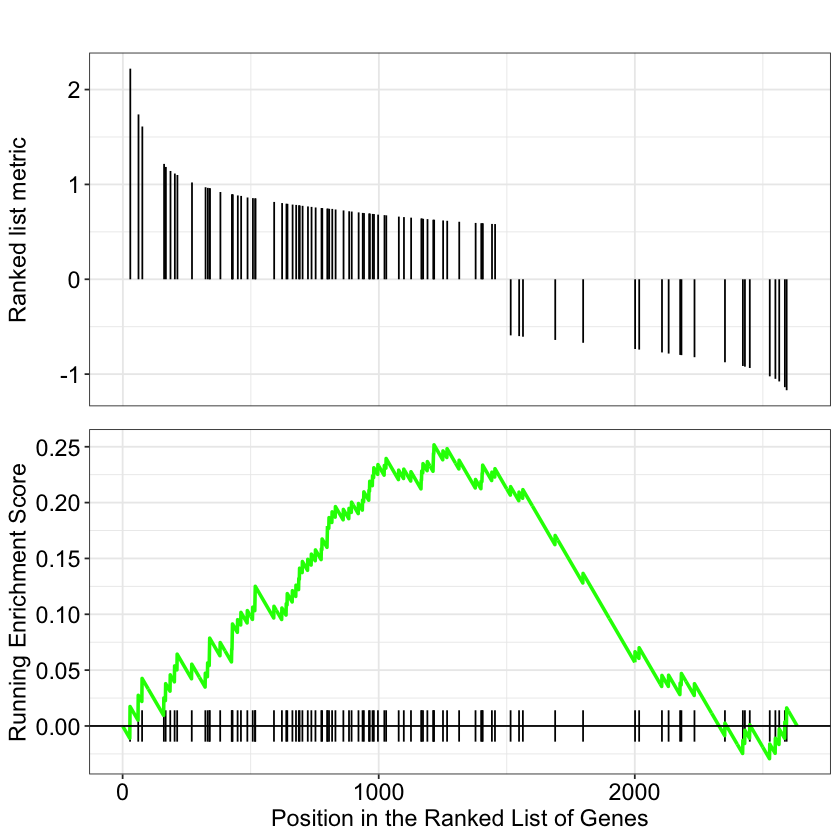

In [104]:
# GSEA using gene sets associated with BP Gene Ontology terms
gseaGO <- gseGO(geneList = foldchanges, 
              OrgDb = org.Mm.eg.db, 
              ont = 'BP', 
              nPerm = 1000, 
              minGSSize = 20, 
              pvalueCutoff = 0.05,
              verbose = FALSE) 

gseaGO_results <- gseaGO@result

gseaplot(gseaGO, geneSetID = 'GO:0007423')

The SPIA (Signaling Pathway Impact Analysis) tool can be used to integrate the lists of differentially expressed genes, their fold changes, and pathway topology to identify affected pathways.

In [107]:
annotations_entrez <- AnnotationDbi::select(EnsDb.Mmusculus.v79,
                                           keys = rownames(data),
                                           columns = c("SYMBOL", "ENTREZID"),
                                           keytype = "GENEID")

In [108]:
background_entrez <- annotations_entrez$ENTREZID
sig_res_entrez <- res_entrez[which(res_entrez$padj < 0.05), ]
sig_entrez <- sig_res_entrez$log2FoldChange
names(sig_entrez) <- sig_res_entrez$ENTREZID

In [109]:
length(sig_entrez)

[1] 2634

In [110]:
length(background_entrez)

[1] 26550

In [111]:
spia_result <- spia(de = sig_entrez, all = background_entrez, organism = "mmu")


Done pathway 1 : RNA transport..
Done pathway 2 : RNA degradation..
Done pathway 3 : PPAR signaling pathway..
Done pathway 4 : Fanconi anemia pathway..
Done pathway 5 : MAPK signaling pathway..
Done pathway 6 : ErbB signaling pathway..
Done pathway 7 : Calcium signaling pathway..
Done pathway 8 : Cytokine-cytokine receptor int..
Done pathway 9 : Chemokine signaling pathway..
Done pathway 10 : NF-kappa B signaling pathway..
Done pathway 11 : Phosphatidylinositol signaling..
Done pathway 12 : Neuroactive ligand-receptor in..
Done pathway 13 : Cell cycle..
Done pathway 14 : Oocyte meiosis..
Done pathway 15 : p53 signaling pathway..
Done pathway 16 : Sulfur relay system..
Done pathway 17 : SNARE interactions in vesicula..
Done pathway 18 : Regulation of autophagy..
Done pathway 19 : Protein processing in endoplas..
Done pathway 20 : Lysosome..
Done pathway 21 : mTOR signaling pathway..
Done pathway 22 : Apoptosis..
Done pathway 23 : Vascular smooth muscle contrac..
Done pathway 24 : Wnt s

In [112]:
head(spia_result)

Name,ID,pSize,NDE,pNDE,tA,pPERT,pG,pGFdr,pGFWER,Status,KEGGLINK
<chr>,<chr>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
Huntington's disease,05016,161,74,3.847081e-32,-1.610134,0.489000,1.393060e-30,1.810979e-28,1.810979e-28,Inhibited,http://www.genome.jp/dbget-bin/show_pathway?mmu05016+104130+17991+17992+17993+225887+230075+407785+54405+595136+66046+66091+66218+66377+66414+66416+66495+66916+67130+67264+68194+68197+68202+68342+68375+69875+72900+75406+78330+66925+66945+67680+22272+66152+66576+66594+67530+110323+12857+12859+12861+12864+12865+12866+12867+12869+20463+66142+11949+11950+28080+67126+67942+15194+15114+328572+20020+20022+231329+245841+66420+67710+69241+14810+18797+16438+13063+14775+11771+13191+110084+68922+21817+208647+26427
Alzheimer's disease,05010,152,69,1.200002e-29,-4.652156,0.297000,2.452273e-28,1.593977e-26,3.187955e-26,Inhibited,http://www.genome.jp/dbget-bin/show_pathway?mmu05010+11820+13063+104130+17991+17992+17993+225887+230075+407785+54405+595136+66046+66091+66218+66377+66414+66416+66495+66916+67130+67264+68194+68197+68202+68342+68375+69875+72900+75406+78330+66925+66945+67680+22272+66152+66576+66594+67530+11949+11950+28080+67126+67942+110323+12857+12859+12861+12864+12865+12866+12867+12869+20463+66142+16438+16439+11937+11938+18797+14810+14814+12288+12292+15108+14102+18125+70405+16971+16176
Parkinson's disease,05012,120,53,2.088692e-22,-3.310093,0.520000,5.601582e-21,2.427352e-19,7.282057e-19,Inhibited,http://www.genome.jp/dbget-bin/show_pathway?mmu05012+13063+104130+17991+17992+17993+225887+230075+407785+54405+595136+66046+66091+66218+66377+66414+66416+66495+66916+67130+67264+68194+68197+68202+68342+68375+69875+72900+75406+78330+66925+66945+67680+22272+66152+66576+66594+67530+110323+12857+12859+12861+12864+12865+12866+12867+12869+20463+66142+11949+11950+28080+67126+67942
Focal adhesion,04510,175,55,2.978477e-15,51.388225,0.001000,1.231753e-16,4.003197e-15,1.601279e-14,Activated,http://www.genome.jp/dbget-bin/show_pathway?mmu04510+192897+109700+319480+68794+107589+213435+238564+13367+17931+19045+19878+170736+64099+22330+11474+18750+19417+12815+12827+12831+12832+12833+12835+12842+12843+14268+16773+16775+16776+16777+16779+21826+21827+21828+21923+21960+22371+245026+68553+13649+13866+14254+14257+16001+16542+17295+18596+14205+16000+18654+12927+109905+215449+330662+22325
ECM-receptor interaction,04512,78,28,5.959248e-10,16.020712,0.000005,1.026390e-13,2.668615e-12,1.334308e-11,Activated,http://www.genome.jp/dbget-bin/show_pathway?mmu04512+16773+16775+16776+16777+16779+12815+12827+12831+12832+12833+12835+12842+12843+245026+68553+21923+21960+22371+14268+21826+21827+21828+64051+75209+192897+319480+109700+12505
Calcium signaling pathway,04020,165,43,2.322845e-09,4.603006,0.499000,2.500829e-08,5.418463e-07,3.251078e-06,Activated,http://www.genome.jp/dbget-bin/show_pathway?mmu04020+104111+18125+110891+20541+12322+18750+74055+13649+13866+13867+18596+14810+14814+18436+18803+107589+213435+238564+16438+16439+20191+18797+12288+12292+12286+12287+12290+15558+16867+18216+21390+58861+70405+21924+11515+11937+11938+13492+12291+239556+320707+67972+20866


In [113]:
write.csv(spia_result, "results/csv/SPIA_results.csv", quote=F)

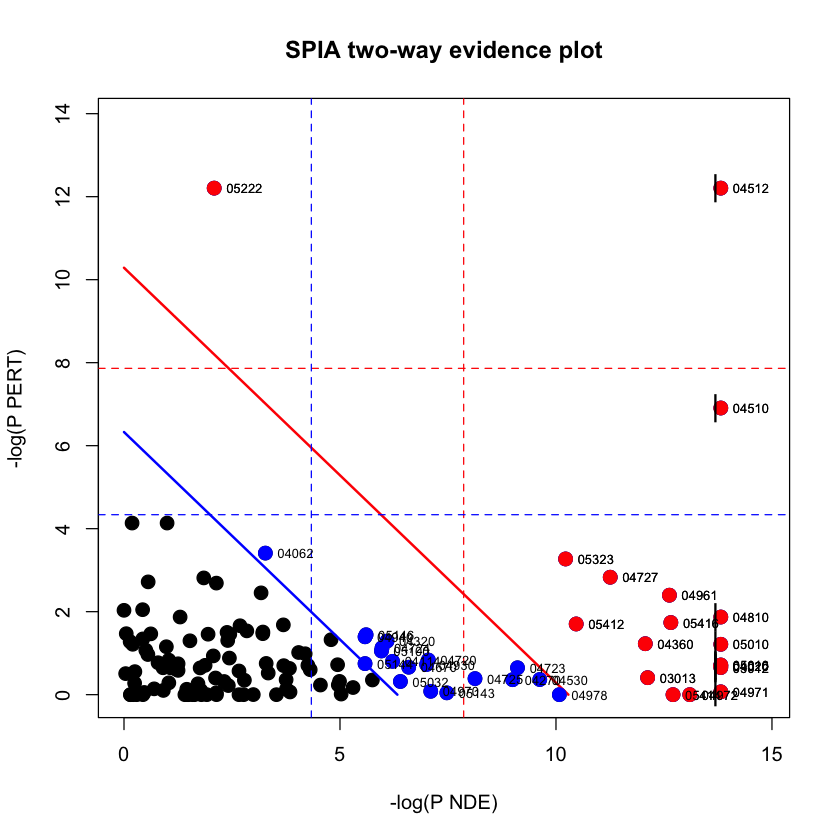

In [124]:
spia_plot <- plotP(spia_result, threshold=0.05)

In [127]:
save_spia <- function(x, filename, width=1100, height=900, res = 100) {
   stopifnot(!missing(x))
   stopifnot(!missing(filename))
   png(filename, width = width, height=height, res = res)
   grid::grid.newpage()
   grid::grid.draw(x$gtable)
   dev.off()
}

In [128]:
save_pheatmap(spia_plot, filename="results/SPIA_plot.png")

pdf 
  2